### Phát biểu bài toán:

-   Phân tích mức độ ảnh hưởng của phần cứng và thương hiệu đến giá của điện thoại di động

### Nguồn Dữ liệu:

-   Dữ liệu được thu thập từ trang web:
    -   https://mobilecity.vn/dien-thoai
    -   https://cellphones.com.vn/mobile.html

Phân tích dữ liệu nhằm khảo sát tính khả thi cho việc xây dựng mô hình dự đoán biến mục tiêu (target variable) "Giá - Price" từ các biến/đặc trưng phần cứng và thương hiệu Xi (i=1..N).
Vì biến đăng trưng Y là biến số liên tục (continuous variable) -> việc mô hình hóa là bài toán hồi quy (regression).

### Các bước thực hiện:

-   Bước 1: Khai thác dữ liệu (Data Exploration)
-   Bước 2: Tiền xử lý dữ liệu (Data Preprocessing)
-   Bước 3: Phân tích dữ liệu (Data Analysis)
-   Bước 4: Xây dựng mô hình hồi quy (Regression Model Building)

### Vì phạm vi của bài toán là thu thập và phân tích dữ liệu, nên chúng ta sẽ không đi sâu vào bước 4 (xây dựng mô hình hồi quy - Bài tập sau).


# Bước 2: Clean Data

Trong notebook này, chúng ta sẽ thực hiện các bước sau:

1. Tổng quan về dữ liệu ban đầu
2. Xác định vấn đề cần làm sạch
3. Làm sạch dữ liệu
    1. Xử lý giá trị thiếu
    2. Chuẩn hóa định dạng dữ liệu
    3. Xử lý dữ liệu ngoại lai (outliers)
4. Trực quan hóa phân bố dữ liệu trước và sau xử lý
5. Tổng kết việc làm sạch dữ liệu


In [1126]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np


base_data_path = '../data/processed/'
base_data_clean_path = '../data/clean/'
# filtered_data_name = 'filtered_products_mobilecity.json'
filtered_data_name = 'filtered_products.json'
extracted_features_name = 'extracted_features.csv'
cleaned_data_name = 'cleaned_data.csv'
feature_engineering_name = 'feature_engineering.csv'


## 1. Tổng quan về dữ liệu ban đầu


### A. Extract feature


In [1127]:
def extract_feature(text, patterns):
    """
    Dùng regex để trích xuất giá trị đầu tiên khớp với các pattern.
    """
    if not text:
        return None
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            return match.group(1).strip()
    return None

### B. Định nghĩa hàm process_product để trích xuất các đặc trưng

Hàm này sẽ đọc thông tin từ trường specifications của mỗi sản phẩm, hợp nhất các thông tin cần thiết, sau đó trích xuất các đặc trưng như:

-   Chipset
-   CPU
-   RAM
-   Bộ nhớ trong
-   Màn hình
-   Camera
-   Pin
-   Tính năng bảo mật
-   Giá.


##### 1. Hàm chuẩn bị dữ liệu


In [1128]:
def prepare_product_data(product):
    """Hàm chuẩn bị dữ liệu từ sản phẩm"""
    # Khởi tạo dictionary các đặc trưng
    features = {
        'name': product.get('name'),
        'url': product.get('url'),
        'price': product.get('price'),
        'chipset': None,
        # 'cpu_cores': None,
        # 'cpu_speed': None,
        'ram': None,
        'internal_memory': None,
        'screen_size': None,
        'screen_resolution': None,
        'screen_tech': None,
        'refresh_rate': None,
        'camera_main_resolution': None,
        'camera_count': None,
        'battery_capacity': None,
        'security': None
    }
    
    # Hợp nhất tất cả thông tin trong specifications
    spec_details = {}
    for spec in product.get('specifications', []):
        details = spec.get('details', {})
        for key, value in details.items():
            if isinstance(value, list):
                value = " | ".join(value)
            spec_details[key.lower()] = str(value)
    
    return features, spec_details

##### 2. Hàm xử lý giá


In [1129]:
def process_price(features, price_text):
    """Trích xuất thông tin giá"""
    if price_text:
        try:
            # Thử chuyển đổi trực tiếp nếu là số sạch
            price_clean = str(price_text).replace(',', '').replace('.', '')
            features["price"] = int(price_clean) if price_clean.isdigit() else None
        except (ValueError, TypeError, AttributeError):
            # Nếu không thành công, thử trích xuất bằng regex
            price_match = re.search(r'(\d+[\d\.]*)', str(price_text))
            if price_match:
                try:
                    features["price"] = int(price_match.group(1).replace(',', '').replace('.', ''))
                except (ValueError, TypeError):
                    features["price"] = None
            else:
                features["price"] = None
    else:
        features["price"] = None
    
    return features

##### 3. Hàm xử lý CPU/Chipset


In [1130]:
def process_chipset(features, spec_details):
    """Trích xuất thông tin chipset và CPU từ spec_details."""
    
    chipset_val = spec_details.get("chipset")

    if chipset_val:
        # Tách theo " | " nếu có nhiều phần tử
        parts = chipset_val.split(" | ")
        
        # CPU thường nằm ở phần tử đầu tiên
        cpu_info = parts[0] if parts else None
    else:
        cpu_info = None

    # Lưu vào features
    features["chipset"] = chipset_val
    features["cpu"] = cpu_info
    return features
    


##### 4. Hàm xử lý bộ nhớ


In [1131]:
import re

def process_memory(features, spec_details):
    """Trích xuất thông tin RAM và bộ nhớ trong, lưu dưới dạng GB"""
    # Xử lý RAM
    ram_text = (spec_details.get("ram") or 
                spec_details.get("dung lượng ram") or 
                spec_details.get("RAM & lưu trữ"))
    if ram_text:
        ram_text = str(ram_text).lower()
        
        # Tìm kiếm GB
        gb_match = re.search(r'(\d+(\.\d+)?)\s*(?:gb|g\b)', ram_text, re.IGNORECASE)
        if gb_match:
            features['ram'] = float(gb_match.group(1))
        else:
            # Nếu chỉ có số, giả sử đơn vị là GB
            num_match = re.search(r'(\d+(\.\d+)?)', ram_text)
            if num_match:
                features['ram'] = float(num_match.group(1))

    # Xử lý bộ nhớ trong (ROM)
    rom_text = (spec_details.get("bộ nhớ trong (rom)") or 
                spec_details.get("bộ nhớ trong"))
    if rom_text:
        rom_text = str(rom_text).lower()
        
        # Tìm kiếm TB (terabyte) -> chuyển sang GB
        tb_match = re.search(r'(\d+(\.\d+)?)\s*(?:tb|t\b)', rom_text, re.IGNORECASE)
        if tb_match:
            features['internal_memory'] = float(tb_match.group(1)) * 1024
        else:
            # Tìm kiếm GB
            gb_match = re.search(r'(\d+(\.\d+)?)\s*(?:gb|g\b)', rom_text, re.IGNORECASE)
            if gb_match:
                features['internal_memory'] = float(gb_match.group(1))
            else:
                # Nếu chỉ có số, giả sử đơn vị là GB
                num_match = re.search(r'(\d+(\.\d+)?)', rom_text)
                if num_match:
                    features['internal_memory'] = float(num_match.group(1))

# Làm tròn GB nếu có thể
    if 'ram' in features and features['ram'] is not None:
        if isinstance(features['ram'], float):
            features['ram'] = int(features['ram']) if features['ram'].is_integer() else features['ram']
    
    if 'internal_memory' in features and features['internal_memory'] is not None:
        if isinstance(features['internal_memory'], float):
            features['internal_memory'] = int(features['internal_memory']) if features['internal_memory'].is_integer() else features['internal_memory']
    return features


##### 5. Hàm xử lý màn hình


In [1132]:
def process_screen(features, spec_details):
    """Trích xuất thông tin màn hình"""
    # Kích thước màn hình
    screen_size_text = (spec_details.get("kích thước màn hình") or 
                        spec_details.get("màn hình rộng"))
    if screen_size_text:
        # Nếu là list, lấy thông tin màn hình chính
        if isinstance(screen_size_text, list):
            main_screen = None
            for item in screen_size_text:
                if "màn chính" in item.lower() or "chính" in item.lower():
                    main_screen = item
                    break
            if main_screen:
                screen_size_text = main_screen
            else:
                screen_size_text = screen_size_text[0]  # Lấy phần tử đầu tiên nếu không tìm thấy "màn chính"

        inches_match = re.search(r'([\d\.|\,]+)\s*inches?', screen_size_text)
        if inches_match:
            features['screen_size'] = inches_match.group(1)
        else:
            num_match = re.search(r'([\d\.]+)', screen_size_text)
            if num_match:
                features['screen_size'] = num_match.group(1)
    
    # Độ phân giải màn hình
    resolution_text = (spec_details.get("độ phân giải màn hình") or 
                    spec_details.get("độ phân giải") or 
                    spec_details.get("Tính năng màn hình"))

    if resolution_text:
        # Nếu là list, lấy thông tin màn hình chính
        if isinstance(resolution_text, list):
            main_resolution = None
            for item in resolution_text:
                if "màn chính" in item.lower() or "chính" in item.lower():
                    main_resolution = item
                    break
            if main_resolution:
                resolution_text = main_resolution
            else:
                resolution_text = resolution_text[0]  # Lấy phần tử đầu tiên nếu không tìm thấy "màn chính"
        
        # Tìm độ phân giải theo định dạng tiêu chuẩn (1920 x 1080)
        resolution_match = re.search(r'(\d+)\s*[xX×]\s*(\d+)', str(resolution_text))
        
        if resolution_match:
            features['screen_resolution'] = f"{resolution_match.group(1)} x {resolution_match.group(2)}"
        else:
            # Tìm theo định dạng K (4K, 1.5K, v.v.)
            k_match = re.search(r'([\d\.]+\s*K)', str(resolution_text), re.IGNORECASE)
            if k_match:
                features['screen_resolution'] = k_match.group(1)
            # Tìm các định dạng phổ biến khác
            elif re.search(r'Full HD|FHD|HD\+|HD|UHD|2K|QHD|WQHD', str(resolution_text), re.IGNORECASE):
                resolution_std = re.search(r'(Full HD|FHD|HD\+|HD|UHD|2K|QHD|WQHD)', 
                                        str(resolution_text), re.IGNORECASE).group(1)
                features['screen_resolution'] = resolution_std
            else:
                # Nếu không có pattern nào khớp, lấy nguyên giá trị
                features['screen_resolution'] = resolution_text
    else:
        features['screen_resolution'] = None
            
    # Công nghệ màn hình
    screen_tech_text = (spec_details.get("công nghệ màn hình") or 
                        spec_details.get("loại màn hình"))
    
    if screen_tech_text:
        # Nếu là list, lấy thông tin màn hình chính
        if isinstance(screen_tech_text, list):
            main_tech = None
            for item in screen_tech_text:
                if "màn chính" in item.lower() or "chính" in item.lower():
                    main_tech = item
                    break
            
            if main_tech:
                # Lấy phần sau dấu ":"
                tech_parts = main_tech.split(":", 1)
                if len(tech_parts) > 1:
                    features['screen_tech'] = tech_parts[1].strip()
                else:
                    features['screen_tech'] = main_tech
            else:
                # Nếu không tìm thấy "màn chính", lấy phần tử đầu tiên
                features['screen_tech'] = screen_tech_text[0]
        else:
            # Nếu là string, kiểm tra xem có chứa thông tin về màn hình chính không
            main_tech_match = re.search(r'màn\s+chính\s*:\s*(.*?)(?:,|\.|$|;)', 
                                    str(screen_tech_text), re.IGNORECASE)
            if main_tech_match:
                features['screen_tech'] = main_tech_match.group(1).strip()
            else:
                features['screen_tech'] = screen_tech_text
    else:
        features['screen_tech'] = None
    
    # Tần số quét: lấy số Hz (nếu có chữ "hz" thì chỉ lấy phần số)
    refresh_text = spec_details.get("tần số quét")
    if not refresh_text:
        standard_text = spec_details.get("chuẩn màn hình")
        if standard_text:
            refresh_text = extract_feature(standard_text, [r'(\d+)\s*hz'])
    if refresh_text and isinstance(refresh_text, str):
        match = re.search(r'(\d+)\s*hz', refresh_text, re.IGNORECASE)
        if match:
            refresh_text = int(match.group(1))
    features['refresh_rate'] = refresh_text
    
    return features

##### 6. Hàm xử lý camera


In [1133]:
import re

def process_camera(features, spec_details):
    """Trích xuất thông tin camera"""
    camera_text = spec_details.get("camera sau")  # Chú ý key phải đúng
    if camera_text:
        # Nếu camera_text là danh sách, nối lại thành chuỗi
        if isinstance(camera_text, list):
            camera_text = " ".join(camera_text)

        # Tìm tất cả độ phân giải MP
        main_cam_matches = re.findall(r'(\d+(\.\d+)?)\s*mp', camera_text, re.IGNORECASE)
        if main_cam_matches:
            # Lấy độ phân giải camera chính (cao nhất)
            resolutions = [float(match[0]) for match in main_cam_matches]
            features['camera_main_resolution'] = f"{max(resolutions)} MP"
        
        # Số lượng camera được liệt kê
        features['camera_count'] = len(main_cam_matches)

    return features


##### 7. Hàm xử lý pin


In [1134]:
def process_battery(features, spec_details):
    """Trích xuất thông tin pin"""
    pin_text = spec_details.get("pin") or spec_details.get("dung lượng pin")
    if pin_text:
        pin_text = re.sub(r'\s+', ' ', pin_text).strip()
        battery_match = re.search(r'([\d\.,]+)\s*mAh', pin_text, re.IGNORECASE)
        if battery_match:
            battery_value = re.sub(r'[^\d]', '', battery_match.group(1))
            try:
                features['battery_capacity'] = int(battery_value)
            except ValueError:
                features['battery_capacity'] = None
        else:
            features['battery_capacity'] = None
    
    return features

##### 8. Hàm xử lý kết nối không dây (cải tiến)


In [1135]:
def process_wireless(features, spec_details, product):
    """Trích xuất thông tin kết nối không dây từ tất cả các trường"""
    wireless_set = set()
    
    # Kiểm tra trong tất cả các trường của spec_details
    for key, val in spec_details.items():
        if val:
            lower_val = str(val).lower()
            
            # Tìm kiếm chuẩn mạng di động
            if "5g" in lower_val:
                wireless_set.add("5G")
            if "4g" in lower_val or "lte" in lower_val:
                wireless_set.add("4G")
            if "3g" in lower_val:
                wireless_set.add("3G")
                
            # Tìm kiếm WiFi
            if "wifi" in lower_val or "wi-fi" in lower_val:
                # Thêm phiên bản WiFi nếu có
                wifi_ver = extract_feature(lower_val, [r'wifi\s*([\d\.]+)', r'wi-fi\s*([\d\.]+)'])
                wireless_set.add(f"WiFi {wifi_ver}" if wifi_ver else "WiFi")
                
            # Tìm kiếm Bluetooth
            if "bluetooth" in lower_val:
                bt_ver = extract_feature(lower_val, [r'bluetooth\s*([\d\.]+)'])
                wireless_set.add(f"Bluetooth {bt_ver}" if bt_ver else "Bluetooth")
                
            # Tìm kiếm NFC
            if "nfc" in lower_val:
                wireless_set.add("NFC")
                
            # Tìm kiếm GPS
            if "gps" in lower_val:
                wireless_set.add("GPS")
    
    # Kiểm tra trong tên sản phẩm
    product_name = product.get('name', '').lower()
    if "5g" in product_name:
        wireless_set.add("5G")
    if "4g" in product_name:
        wireless_set.add("4G")
    
    features['wireless'] = ", ".join(wireless_set) if wireless_set else None
    
    return features

##### 9. Hàm xử lý bảo mật


In [1136]:
def process_security(features, spec_details):
    """Trích xuất thông tin bảo mật"""
    security_set = set()
    for key, val in spec_details.items():
        if val:
            lower_val = str(val).lower()
            if "vân tay" in lower_val or "fingerprint" in lower_val:
                security_set.add("Vân tay")
            if "face id" in lower_val or "face unlock" in lower_val or "nhận diện khuôn mặt" in lower_val:
                security_set.add("Face ID")
    
    features['security'] = ", ".join(security_set) if security_set else "Mật khẩu"
    
    return features

##### 10. Hàm chính process_product gọi các hàm con


In [1137]:
def process_product(product):
    """Hàm chính xử lý thông tin sản phẩm"""
    # Chuẩn bị dữ liệu
    features, spec_details = prepare_product_data(product)
    
    # Xử lý từng phần
    features = process_price(features, features['price'])
    features = process_chipset(features, spec_details)
    features = process_memory(features, spec_details)
    features = process_screen(features, spec_details)
    features = process_camera(features, spec_details)
    features = process_battery(features, spec_details)
    # features = process_wireless(features, spec_details, product)
    features = process_security(features, spec_details)
    
    return features

##### 11. Đọc file JSON và chuyển đổi dữ liệu thành DataFrame


In [1138]:
# Đọc file JSON (đảm bảo file 'filtered_products_mobilecity.json' nằm cùng thư mục)
with open(base_data_path + filtered_data_name, 'r', encoding='utf-8') as f:
    products = json.load(f)

# Xử lý từng sản phẩm và trích xuất các features
results = [process_product(prod) for prod in products]

# Chuyển đổi danh sách kết quả thành DataFrame để kiểm tra
df = pd.DataFrame(results)
print(df.head())

# Lưu kết quả ra file CSV để kiểm tra
df.to_csv(base_data_clean_path + extracted_features_name, index=False, encoding='utf-8-sig')


                                     name  \
0             ASUS ROG Phone 6 12GB 256GB   
1      Asus ROG Phone 2 (Snapdragon 855+)   
2  Asus ROG Phone 3 Elite (Strix Edition)   
3                Asus ROG Phone 3 Tencent   
4           Asus ROG Phone 5S (Snap 888+)   

                                                 url       price  \
0  https://cellphones.com.vn/asus-rog-phone-6-12g...  14490000.0   
1   https://mobilecity.vn/asus/asus-rog-phone-2.html  11950000.0   
2  https://mobilecity.vn/asus/asus-rog-phone-3-st...  10750000.0   
3   https://mobilecity.vn/asus/asus-rog-phone-3.html  11450000.0   
4  https://mobilecity.vn/asus/asus-rog-phone-5s.html  14450000.0   

                                             chipset   ram  internal_memory  \
0                Qualcomm ® Snapdragon ® 8+ thế hệ 1  12.0              256   
1  Qualcomm SM8150 Snapdragon 855+ (7 nm) | 8 nhâ...  12.0             1024   
2             Qualcomm SM8250 Snapdragon 865 (7 nm+)  12.0              256   
3  Q

### C. Tổng quan về dữ liệu ban đầu


#### 1. Kích thước và cấu trúc dữ liệu


In [1139]:
# Hiển thị vài hàng đầu tiên của dữ liệu thô
print("Shape của dữ liệu:", df.shape)
df.head()
print ("-------------------------------------------------")
# Hiển thị các cột trong dataset
print("\nCác đặc trưng trong dataset:")
print(df.columns.tolist())

print ("-------------------------------------------------")
# Hiển thị vài mẫu đầu tiên
print("\nMẫu dữ liệu:")
display(df.head())

Shape của dữ liệu: (1224, 15)
-------------------------------------------------

Các đặc trưng trong dataset:
['name', 'url', 'price', 'chipset', 'ram', 'internal_memory', 'screen_size', 'screen_resolution', 'screen_tech', 'refresh_rate', 'camera_main_resolution', 'camera_count', 'battery_capacity', 'security', 'cpu']
-------------------------------------------------

Mẫu dữ liệu:


,name,url,price,chipset,ram,internal_memory,screen_size,screen_resolution,screen_tech,refresh_rate,camera_main_resolution,camera_count,battery_capacity,security,cpu
0,ASUS ROG Phone 6 12GB 256GB,https://cellphones.com.vn/asus-rog-phone-6-12g...,14490000.0,Qualcomm ® Snapdragon ® 8+ thế hệ 1,12.0,256,6.78,1080 x 2448,AMOLED,None,50.0 MP,3,6000.0,Vân tay,Qualcomm ® Snapdragon ® 8+ thế hệ 1
1,Asus ROG Phone 2 (Snapdragon 855+),https://mobilecity.vn/asus/asus-rog-phone-2.html,11950000.0,Qualcomm SM8150 Snapdragon 855+ (7 nm) | 8 nhâ...,12.0,1024,6.59,1080 x 2340,AMOLED,120,48.0 MP,2,6000.0,Mật khẩu,Qualcomm SM8150 Snapdragon 855+ (7 nm)
2,Asus ROG Phone 3 Elite (Strix Edition),https://mobilecity.vn/asus/asus-rog-phone-3-st...,10750000.0,Qualcomm SM8250 Snapdragon 865 (7 nm+),12.0,256,6.59,1080 x 2340,AMOLED,144,64.0 MP,3,6000.0,Mật khẩu,Qualcomm SM8250 Snapdragon 865 (7 nm+)
3,Asus ROG Phone 3 Tencent,https://mobilecity.vn/asus/asus-rog-phone-3.html,11450000.0,Qualcomm SM8250 Snapdragon 865+ (7 nm+) | 8 nh...,16.0,512,6.59,1080 x 2340,AMOLED,144,64.0 MP,3,6000.0,Mật khẩu,Qualcomm SM8250 Snapdragon 865+ (7 nm+)
4,Asus ROG Phone 5S (Snap 888+),https://mobilecity.vn/asus/asus-rog-phone-5s.html,14450000.0,Qualcomm SM8350 Snapdragon 888+ 5G (5 nm) | 8 ...,16.0,512,6.78,1080 x 2448,AMOLED,144,64.0 MP,3,6000.0,Vân tay,Qualcomm SM8350 Snapdragon 888+ 5G (5 nm)


#### 2. Kiểm tra kiểu dữ liệu


In [1140]:
# Kiểm tra kiểu dữ liệu của các cột
print("\nKiểu dữ liệu của các cột:")
df.info()


Kiểu dữ liệu của các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1224 entries, 0 to 1223
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   name                    1224 non-null   object 
 1   url                     1224 non-null   object 
 2   price                   1222 non-null   float64
 3   chipset                 1220 non-null   object 
 4   ram                     1207 non-null   float64
 5   internal_memory         1224 non-null   int64  
 6   screen_size             1224 non-null   object 
 7   screen_resolution       1212 non-null   object 
 8   screen_tech             1208 non-null   object 
 9   refresh_rate            1008 non-null   object 
 10  camera_main_resolution  1223 non-null   object 
 11  camera_count            1224 non-null   int64  
 12  battery_capacity        1195 non-null   float64
 13  security                1224 non-null   object 
 14  cpu          

#### 3. Thống kê mô tả cho các biến số


In [1141]:
# Thống kê mô tả cho các biến số
print("\nThống kê mô tả cho các biến số:")
display(df.describe())

# Đối với các biến danh mục, hiển thị tần suất
categorical_columns = ['chipset', 'screen_tech', 'wireless', 'security']
for col in categorical_columns:
    if col in df.columns:
        print(f"\nPhân bố giá trị cho {col}:")
        display(df[col].value_counts().head(10))


Thống kê mô tả cho các biến số:


,price,ram,internal_memory,camera_count,battery_capacity
count,1.222000e+03,1207.000000,1224.000000,1224.000000,1195.000000
mean,9.885437e+06,10.089478,357.074346,2.620098,5005.467782
std,7.891891e+06,4.465116,289.663171,0.805919,1050.258837
min,7.500000e+05,2.000000,16.000000,0.000000,2900.000000
25%,4.350000e+06,8.000000,128.000000,2.000000,4600.000000
50%,7.210000e+06,8.000000,256.000000,3.000000,5000.000000
75%,1.268000e+07,12.000000,512.000000,3.000000,5062.500000
max,5.125000e+07,64.000000,2128.000000,6.000000,23800.000000



Phân bố giá trị cho chipset:


chipset
Qualcomm SM8475 Snapdragon 8+ Gen 1 (4 nm) | 8 nhân (1x3.19 GHz & 3x2.75 GHz & 4x1.80 GHz) | GPU: Adreno 730               22
Qualcomm SM8750-AB Snapdragon 8 Elite (3 nm) | 8 nhân (2x4.32 GHz & 6x3.53 GHz) | GPU: Adreno 830                          22
Qualcomm SM8550-AB Snapdragon 8 Gen 2 (4 nm) | 8 nhân (1x3.2 GHz & 2x2.8 GHz & 2x2.8 GHz & 3x2.0 GHz) | GPU: Adreno 740    22
Qualcomm SM6375 Snapdragon 695 5G (6 nm) | 8 nhân (2x2.2 GHz & 6x1.7 GHz) | GPU: Adreno 619                                19
Qualcomm SM8650-AB Snapdragon 8 Gen 3 (4 nm) | 8 nhân (1x3.3 GHz & 3x3.2 GHz & 2x3.0 GHz & 2x2.3 GHz) | GPU: Adreno 750    18
Qualcomm SM8450 Snapdragon 8 Gen 1 (4 nm) | 8 nhân (1x3.00 GHz & 3x2.50 GHz & 4x1.80 GHz) | GPU: Adreno 730                16
Qualcomm SM8650-AB Snapdragon 8 Gen 3 (4 nm) | 8 nhân (1x3.3 GHz & 5x3.2 GHz & 2x2.3 GHz) | GPU: Adreno 750                15
Qualcomm SM8550 Snapdragon 8 Gen 2 (4 nm) | 8 nhân (1x3.2 GHz & 2x2.8 GHz & 2x2.8 GHz & 3x2.0 GHz) | GPU: Adre


Phân bố giá trị cho screen_tech:


screen_tech
AMOLED                   360
IPS LCD                  286
OLED                     106
Super AMOLED              90
LTPO AMOLED               65
Dynamic AMOLED 2X         49
Super Retina XDR OLED     39
LTPO OLED                 22
PLS LCD                   16
LCD                       14
Name: count, dtype: int64


Phân bố giá trị cho security:


security
Mật khẩu            651
Vân tay             363
Face ID, Vân tay    165
Face ID              45
Name: count, dtype: int64

#### 4. Kiểm tra dữ liệu thiếu



Thông tin về dữ liệu thiếu:


,Số lượng giá trị thiếu,Phần trăm
refresh_rate,216,17.65
battery_capacity,29,2.37
ram,17,1.39
screen_tech,16,1.31
screen_resolution,12,0.98
cpu,4,0.33
chipset,4,0.33
price,2,0.16
camera_main_resolution,1,0.08


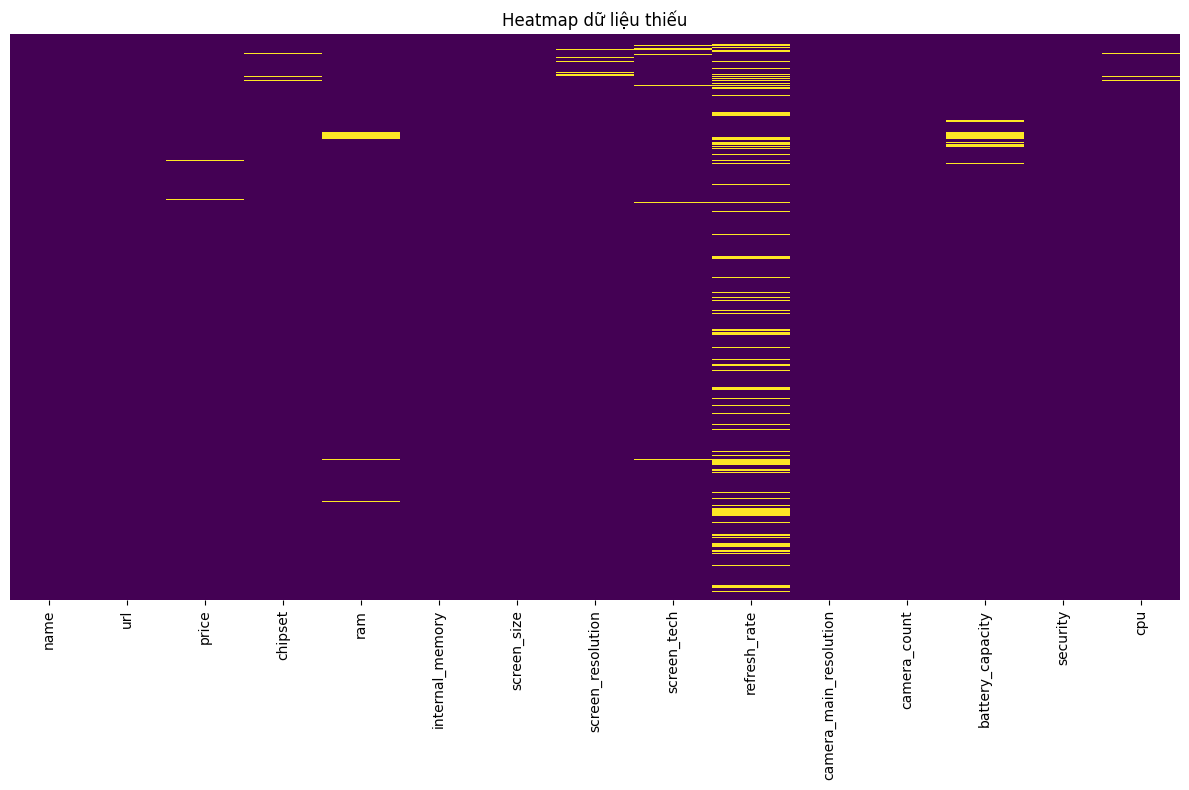

In [1142]:
# Phân tích dữ liệu thiếu
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Số lượng giá trị thiếu': missing_values,
    'Phần trăm': missing_percentage.round(2)
})

# Hiển thị các cột có giá trị thiếu
print("\nThông tin về dữ liệu thiếu:")
display(missing_data[missing_data['Số lượng giá trị thiếu'] > 0].sort_values('Phần trăm', ascending=False))

# Vẽ heatmap dữ liệu thiếu
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Heatmap dữ liệu thiếu')
plt.tight_layout()
plt.show()

#### 5. Trực quan hóa phân bố của các biến chính


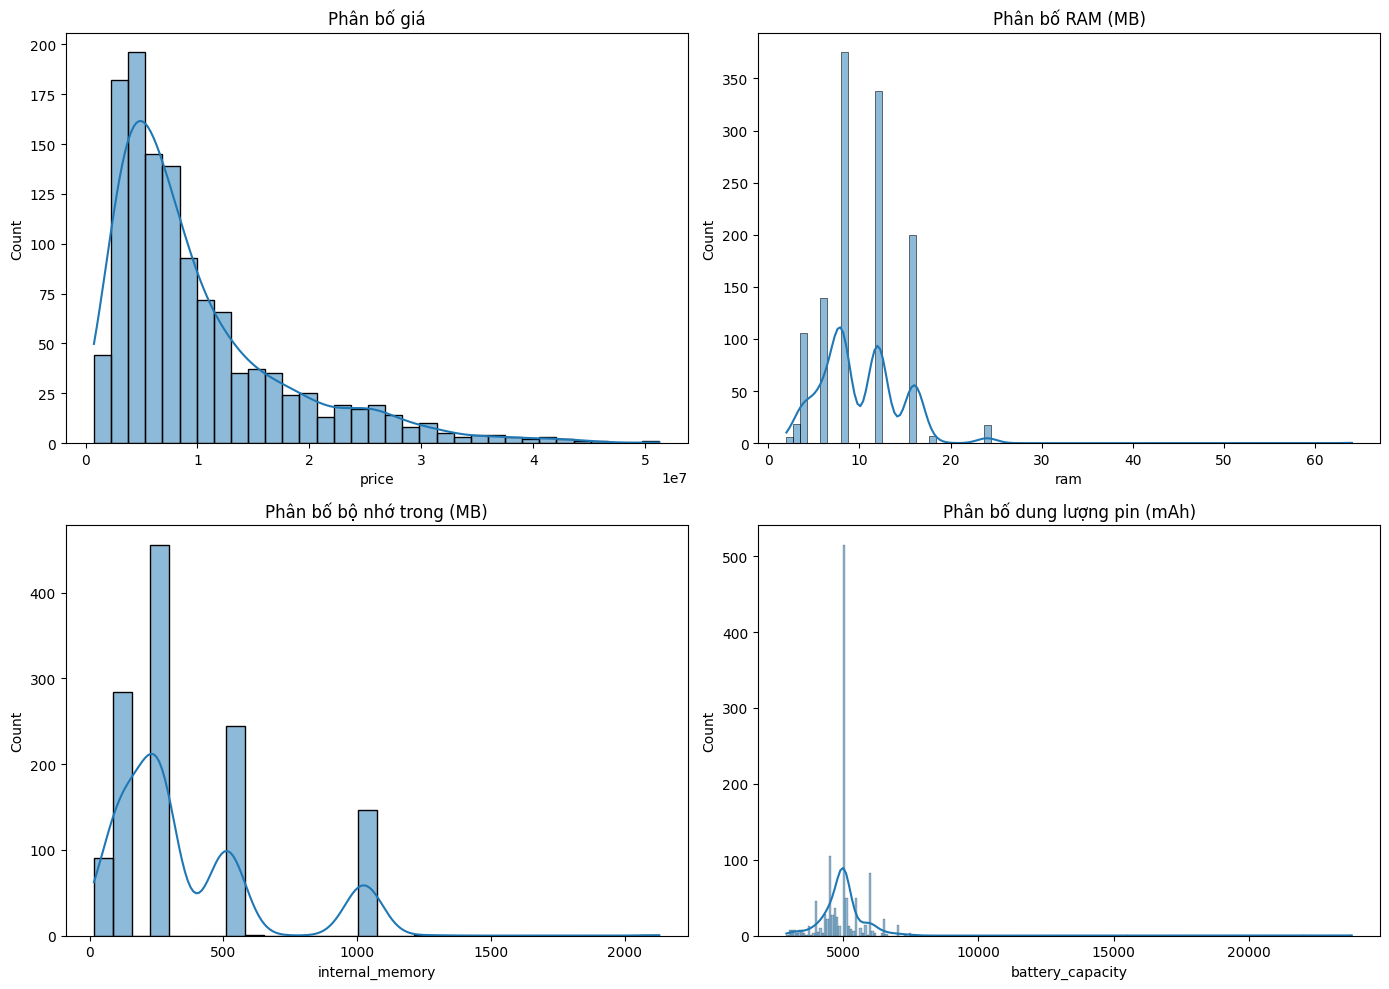

In [1143]:
# Vẽ phân bố của 4 biến số quan trọng
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Phân bố giá
if 'price' in df.columns:
    sns.histplot(df['price'].dropna(), kde=True, ax=axes[0, 0])
    axes[0, 0].set_title('Phân bố giá')

# Phân bố RAM
if 'ram' in df.columns:
    sns.histplot(df['ram'].dropna(), kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Phân bố RAM (MB)')

# Phân bố bộ nhớ trong
if 'internal_memory' in df.columns:
    sns.histplot(df['internal_memory'].dropna(), kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Phân bố bộ nhớ trong (MB)')

# Phân bố dung lượng pin
if 'battery_capacity' in df.columns:
    sns.histplot(df['battery_capacity'].dropna(), kde=True, ax=axes[1, 1])
    axes[1, 1].set_title('Phân bố dung lượng pin (mAh)')

plt.tight_layout()
plt.show()

#### 6. Kiểm tra outliers


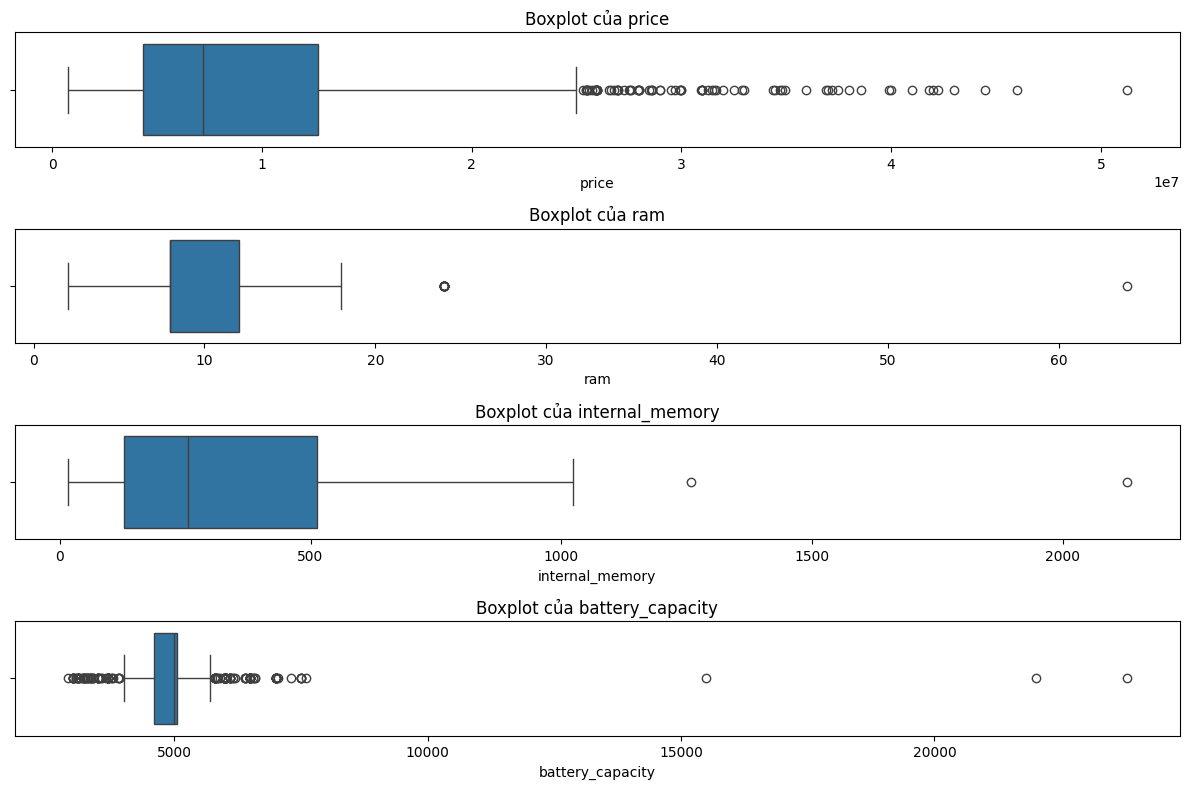

In [1144]:
# Vẽ boxplot cho các biến số chính
numeric_cols = ['price', 'ram', 'internal_memory', 'battery_capacity']
numeric_cols = [col for col in numeric_cols if col in df.columns]

if numeric_cols:
    plt.figure(figsize=(12, len(numeric_cols) * 2))
    for i, col in enumerate(numeric_cols, 1):
        plt.subplot(len(numeric_cols), 1, i)
        sns.boxplot(x=df[col].dropna())
        plt.title(f'Boxplot của {col}')
        plt.tight_layout()
    plt.show()

#### 7. Mối tương quan ban đầu giữa các biến


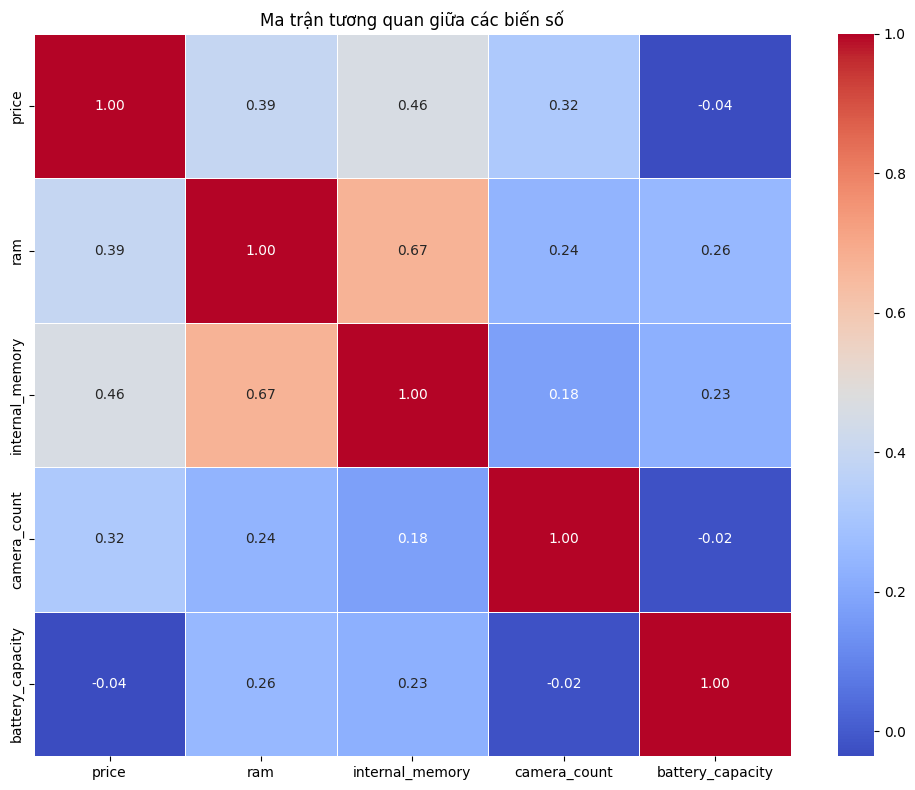

In [1145]:
# Tính ma trận tương quan giữa các biến số
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
if len(numeric_cols) > 1:
    plt.figure(figsize=(10, 8))
    corr_matrix = df[numeric_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Ma trận tương quan giữa các biến số')
    plt.tight_layout()
    plt.show()

#### 8. Phân tích biến mục tiêu (price)


Top 5 biến có tương quan cao nhất với price:
price               1.000000
internal_memory     0.458270
ram                 0.393551
camera_count        0.323340
battery_capacity   -0.035975
Name: price, dtype: float64


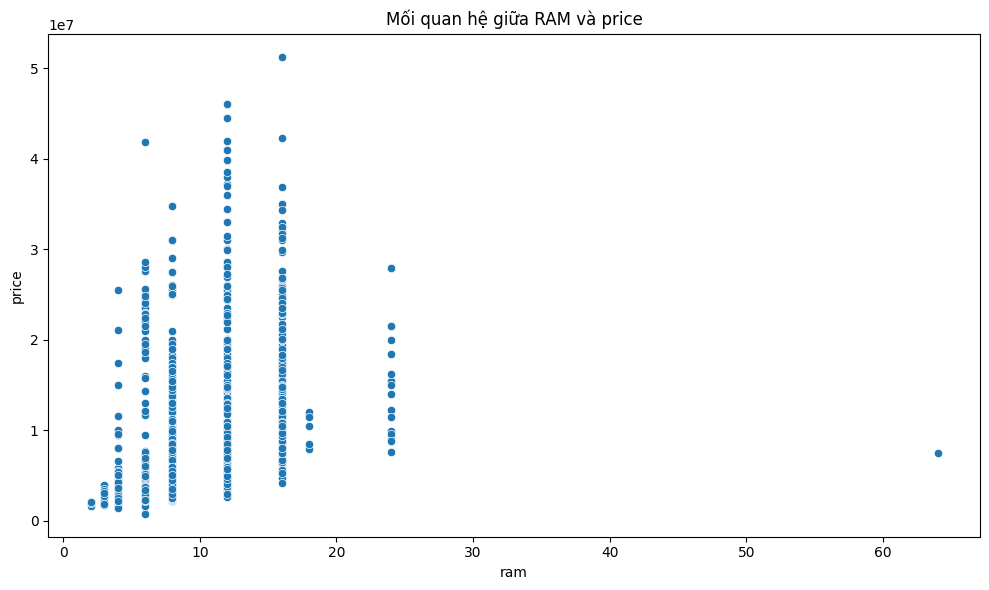

In [1146]:
# Giả sử 'price' là biến mục tiêu
target = 'price'
if target in df.columns:
    # Top 5 biến có tương quan cao nhất với price
    if len(numeric_cols) > 1:
        correlations = df[numeric_cols].corr()[target].sort_values(ascending=False)
        print(f"Top 5 biến có tương quan cao nhất với {target}:")
        print(correlations.head(6))  # +1 vì có chính nó
        
    # Scatter plot giữa RAM và giá
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='ram', y=target)
    plt.title(f'Mối quan hệ giữa RAM và {target}')
    plt.tight_layout()
    plt.show()

#### 9. Kết luận ban đầu


Kết luận ban đầu:

-   Tương quan với giá sản phẩm:
    -   Các yếu tố ảnh hưởng mạnh đến giá bán điện thoại (theo thứ tự giảm dần): screen_width (0.65), total_pixels (0.50), RAM (0.40), aspect_ratio (0.39), và internal_memory (0.33)
    -   Kích thước màn hình có ảnh hưởng lớn nhất đến giá bán, theo sau là tổng số điểm ảnh
-   Phân bố dữ liệu:
    -   Phần lớn điện thoại tập trung ở phân khúc giá thấp đến trung bình, với một số ít mẫu cao cấp có giá cao hơn đáng kể
    -   RAM phổ biến nhất là 4GB-8GB, với xu hướng tăng ở các thiết bị cao cấp
    -   Dung lượng pin tập trung chủ yếu quanh mức 5000mAh
-   Phân khúc thị trường:

    -   Bảo mật: Phần lớn sản phẩm sử dụng mật khẩu (669 sản phẩm) hoặc vân tay (363 sản phẩm)
    -   Phân phối chipset không đồng đều, cho thấy sự đa dạng về nhà sản xuất chip

-   Thiếu dữ liệu:
    -   28 sản phẩm thiếu thông tin RAM (chủ yếu là iPhone 16 và một số thiết bị cơ bản)
    -   7 sản phẩm thiếu thông tin chipset, đã được xử lý bằng cách gán giá trị "Không xác định"


## 2. DATA CLEANING


##### Xử lý dữ liêu trùng cùng tên và cùng giá


In [1147]:
# Xóa các dòng trùng theo name + price, giữ lại bản ghi đầu tiên
df_cleaned = df.drop_duplicates(subset=['name', 'price'])

# Lưu lại file đã lọc
df_cleaned.to_csv(base_data_clean_path + cleaned_data_name, index=False, encoding="utf-8-sig")

# Hiển thị số lượng bản ghi trước và sau khi lọc
print(f"Số lượng bản ghi ban đầu: {len(df)}")
print(f"Số lượng bản ghi sau khi lọc: {len(df_cleaned)}")

Số lượng bản ghi ban đầu: 1224
Số lượng bản ghi sau khi lọc: 1217


##### Feature engineering: Trích xuất thông tin thương hiệu từ tên sản phẩm


In [1148]:
import pandas as pd

def extract_brand(name):
    # Convert to lowercase for easier matching
    name_lower = name.lower()
    
    # Define brand patterns
    brand_patterns = {
        'iphone': 'Apple',
        'apple': 'Apple',
        'samsung': 'Samsung',
        'xiaomi': 'Xiaomi',
        'asus': 'Asus',
        'bphone': 'Bphone',
        'redmi': 'Xiaomi',
        'infinix': 'Infinix',
        'inoi': 'Inoi',
        'itel': 'Itel',
        'nokia': 'Nokia',
        'sony': 'Sony',
        'nothing': 'Nothing',
        'nubia': 'Nubia',
        'poco': 'Xiaomi',
        'huawei': 'Huawei',
        'vivo': 'Vivo',
        'oppo': 'OPPO',
        'honor': 'Honor',
        'realme': 'Realme',
        'tecno': 'Tecno',
        'viettel': 'Viettel',
        'vsmart': 'Vsmart',
        'zte': 'ZTE',
        'google': 'Google',
        'meizu': 'Meizu',
        'motorola': 'Motorola',
        'moto': 'Motorola',
        'nio phone': 'NIO Phone',
        'nothing': 'Nothing',
        'oneplus': 'OnePlus',
        'tesla': 'Tesla',
        'unihertz': 'Unihertz',
        'lenovo': 'Lenovo',
        'red magic': 'Red Magic',
        'moonstone': 'Moonstone',
        'leeco': 'LeEco',
        'blackview': 'Blackview',
        'benco': 'Benco',
        'fairphone': 'Fairphone',
        'ulefone': 'Ulefone',
        'smartisan': 'Smartisan',
        'moondrop': 'Moondrop',
        'gionee': 'Gionee',
        'blu': 'Blu',
    }
    
    # Try to match brand at the start of the name
    for pattern, brand in brand_patterns.items():
        if name_lower.startswith(pattern):
            return brand
    
    # Look for brand anywhere in the name
    for pattern, brand in brand_patterns.items():
        if pattern in name_lower:
            return brand
    
    return 'Other'

def extract_os(brand):
    if brand == 'Apple':
        return 'iOS'
    else:
        return 'Android'

def extract_brand_and_os(df):
    # Extract brand
    df['brand'] = df['name'].apply(extract_brand)
    
    # Infer OS based on brand
    df['os'] = df['brand'].apply(extract_os)
    
    return df

# Load your data
df = pd.read_csv(base_data_clean_path + cleaned_data_name)

# Apply feature engineering
df = extract_brand_and_os(df)

# Preview the results
print(df[['name', 'brand', 'os']].head(10))

# Save the enhanced dataset
df.to_csv(base_data_clean_path + cleaned_data_name, index=False)

                                                name brand       os
0                        ASUS ROG Phone 6 12GB 256GB  Asus  Android
1                 Asus ROG Phone 2 (Snapdragon 855+)  Asus  Android
2             Asus ROG Phone 3 Elite (Strix Edition)  Asus  Android
3                           Asus ROG Phone 3 Tencent  Asus  Android
4                      Asus ROG Phone 5S (Snap 888+)  Asus  Android
5               Asus ROG Phone 5 5G (Snapdragon 888)  Asus  Android
6                                  Asus ROG Phone 6D  Asus  Android
7                         Asus ROG Phone 6D Ultimate  Asus  Android
8  Asus ROG Phone 6 (Snapdragon 8+ Gen 1, pin 600...  Asus  Android
9                               Asus ROG Phone 6 Pro  Asus  Android


##### Thông tin về dữ liệu thiếu:


In [1149]:
# Phân tích dữ liệu thiếu
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Số lượng giá trị thiếu': missing_values,
    'Phần trăm': missing_percentage.round(2)
})

# Hiển thị các cột có giá trị thiếu
print("\nThông tin về dữ liệu thiếu:")
display(missing_data[missing_data['Số lượng giá trị thiếu'] > 0].sort_values('Phần trăm', ascending=False))



Thông tin về dữ liệu thiếu:


,Số lượng giá trị thiếu,Phần trăm
refresh_rate,215,17.67
battery_capacity,29,2.38
ram,17,1.40
screen_tech,14,1.15
screen_resolution,12,0.99
cpu,4,0.33
chipset,4,0.33
price,2,0.16
camera_main_resolution,1,0.08


#### 1. RAM và Internal Memory (Bộ nhớ)


Do dữ liêu ram bị miss tương đối ít nên em dùng cách: tạo phân khúc giá


/tmp/ipykernel_10757/167578547.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['ram'] = df.groupby('price_segment')['ram'].transform(
/tmp/ipykernel_10757/167578547.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ram'].fillna(df['ram'].median(), inplace=True)


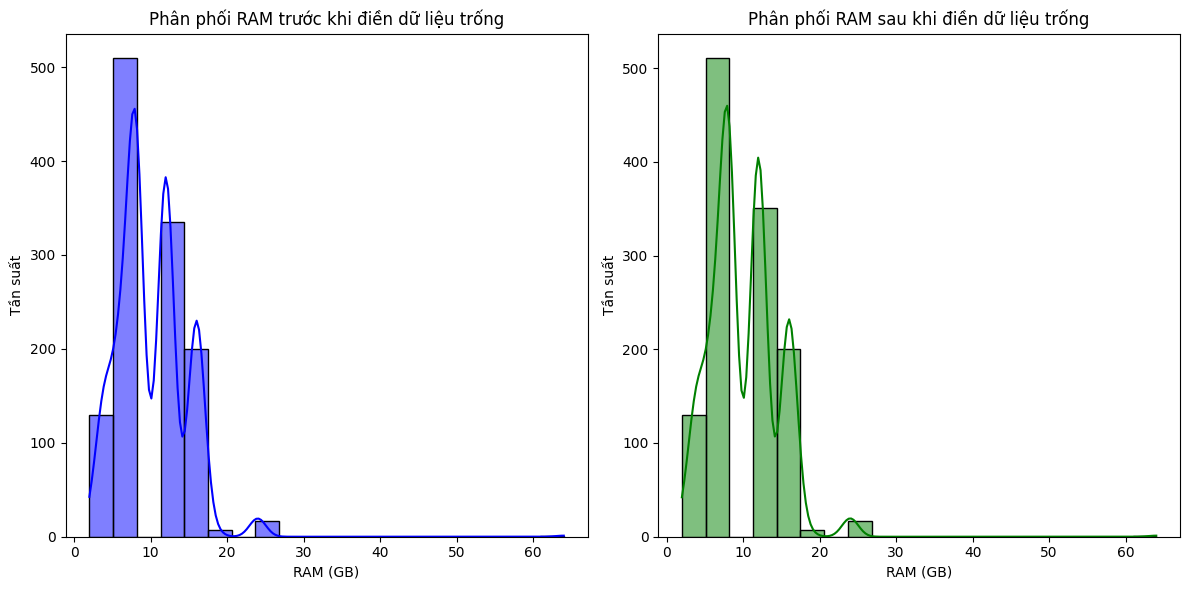

Đã điền xong giá trị thiếu cho RAM.


In [1150]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vẽ biểu đồ trước khi điền dữ liệu trống
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['ram'], kde=True, bins=20, color='blue')
plt.title('Phân phối RAM trước khi điền dữ liệu trống')
plt.xlabel('RAM (GB)')
plt.ylabel('Tần suất')

# Tạo nhóm lớn hơn dựa trên phân khúc giá hoặc đặc điểm kỹ thuật
df['price_segment'] = pd.qcut(df['price'].fillna(df['price'].median()), 
                             q=3, 
                             labels=['Low', 'Medium', 'High'])

# Điền giá trị RAM theo phân khúc giá thay vì theo brand
df['ram'] = df.groupby('price_segment')['ram'].transform(
    lambda x: x.fillna(x.median()) if x.count() >= 3 else x)

# Nếu vẫn còn thiếu, điền bằng giá trị chung
df['ram'].fillna(df['ram'].median(), inplace=True)

# Vẽ biểu đồ sau khi điền dữ liệu trống
plt.subplot(1, 2, 2)
sns.histplot(df['ram'], kde=True, bins=20, color='green')
plt.title('Phân phối RAM sau khi điền dữ liệu trống')
plt.xlabel('RAM (GB)')
plt.ylabel('Tần suất')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

# Kiểm tra và thông báo
if df['ram'].isnull().sum() == 0:
    print("Đã điền xong giá trị thiếu cho RAM.")

# không lưu price_segment
df.drop(columns=['price_segment'], inplace=True)

# Lưu kết quả ra file CSV
df.to_csv(base_data_clean_path + "cleaned_data.csv", index=False, encoding='utf-8-sig')

#### 2. Xử lý dữ liệu thiếu trong cột giá


In [1151]:
# Kiểm tra số lượng giá trị thiếu
missing_price = df['price'].isna().sum()
print(f"Số sản phẩm thiếu giá: {missing_price} ({missing_price/len(df):.2%})")

# Loại bỏ các dòng thiếu giá nếu số lượng ít
if missing_price/len(df) < 0.05:
    df = df.dropna(subset=['price'])
    print(f"Đã loại bỏ {missing_price} dòng thiếu giá.")


Số sản phẩm thiếu giá: 2 (0.16%)
Đã loại bỏ 2 dòng thiếu giá.


### 3. Tốc độ làm mới màn hình


Lý do chọn 60Hz để điền giá trị thiếu:

1. 60Hz là tần số quét tiêu chuẩn trong ngành công nghiệp điện thoại di động
2. Hầu hết các điện thoại không quảng cáo tần số quét đều mặc định là 60Hz
3. Phân khúc phổ thông và trung cấp thường sử dụng màn hình 60Hz
4. Đây là giá trị an toàn nhất để không tạo ra sai lệch về hiệu năng khi phân tích


Phân bố refresh_rate trước khi điền:
refresh_rate
60.0      33
90.0     176
120.0    677
144.0     94
165.0     19
180.0      1
240.0      1
Name: count, dtype: int64
Tỷ lệ thiếu của refresh_rate: 17.61%
Phân bố refresh_rate sau khi điền:
refresh_rate
60.0     247
90.0     176
120.0    677
144.0     94
165.0     19
180.0      1
240.0      1
Name: count, dtype: int64


/tmp/ipykernel_10757/1454282712.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['refresh_rate'].fillna(60, inplace=True)


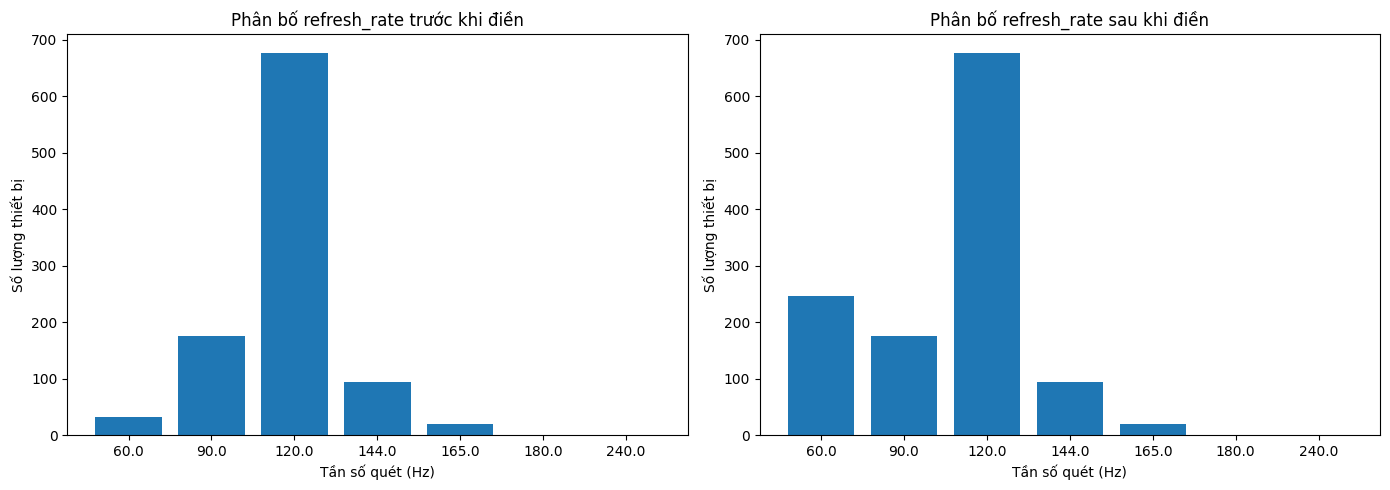

In [1152]:
# Kiểm tra phân bố của refresh_rate trước khi điền
import sys

refresh_rate_counts = df['refresh_rate'].value_counts().sort_index()
print("Phân bố refresh_rate trước khi điền:")
print(refresh_rate_counts)

# Phân tích tỷ lệ thiếu
missing_rate = df['refresh_rate'].isna().mean() * 100
print(f"Tỷ lệ thiếu của refresh_rate: {missing_rate:.2f}%")

df['refresh_rate'].fillna(60, inplace=True)

# Kiểm tra phân bố sau khi điền
refresh_rate_counts_after = df['refresh_rate'].value_counts().sort_index()
print("Phân bố refresh_rate sau khi điền:")
print(refresh_rate_counts_after)

# Tạo biểu đồ so sánh trước và sau khi điền
if 'matplotlib' in sys.modules:
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))
    
    # Trước khi điền
    ax[0].bar(refresh_rate_counts.index.astype(str), refresh_rate_counts.values)
    ax[0].set_title('Phân bố refresh_rate trước khi điền')
    ax[0].set_xlabel('Tần số quét (Hz)')
    ax[0].set_ylabel('Số lượng thiết bị')
    
    # Sau khi điền
    ax[1].bar(refresh_rate_counts_after.index.astype(str), refresh_rate_counts_after.values)
    ax[1].set_title('Phân bố refresh_rate sau khi điền')
    ax[1].set_xlabel('Tần số quét (Hz)')
    ax[1].set_ylabel('Số lượng thiết bị')
    
    plt.tight_layout()
    plt.show()

Sau khi phân tích phân bố dữ liệu hiện có, tôi quyết định điền giá trị thiếu bằng 60Hz vì:

-   60Hz là tần số quét tiêu chuẩn trong ngành công nghiệp điện thoại di động
-   Các thiết bị không ghi rõ tần số quét thường mặc định là 60Hz

Biểu đồ trước và sau khi điền cho thấy việc điền giá trị 60Hz không làm méo mó phân bố dữ liệu tổng thể.


In [1153]:
# thêm 60hz vào các dòng thiếu
df.loc[df['refresh_rate'].isna(), 'refresh_rate'] = 60

if df[df['refresh_rate'].isna()].shape[0] == 0:
    print("Đã điền xong giá trị thiếu cho refresh_rate.")

Đã điền xong giá trị thiếu cho refresh_rate.


### 4. xử lý chipset missing

-   do chỉ có 4 trường chipset thiếu. nên em sẽ thử tìm kiếm các loại đó ở trên mang và sau đó thêm vào


In [1154]:
# Kiểm tra số lượng giá trị chipset thiếu trước khi cập nhật
before_count = df['chipset'].isnull().sum()
print(f"Số lượng dòng thiếu chipset trước khi cập nhật: {before_count}")

# Dictionary chứa thông tin chipset cần cập nhật
chipset_dict = {
    "Nubia Music NFC 4GB 128GB (Bản đặc biệt)": "Unisoc SC9863A",
    "vivo Y03 4GB 128GB": "Helio G85",
    "Vivo Y28": "Helio G85",
    "Samsung Galaxy A51 6GB": "Exynos 9611 8 nhân",
}

# Cập nhật chipset cho các dòng tương ứng
for name, chip in chipset_dict.items():
    # Tìm các dòng có name khớp và chipset đang là null
    mask = (df['name'] == name) & (df['chipset'].isnull())
    if mask.any():
        df.loc[mask, 'chipset'] = chip
        print(f"Đã cập nhật chipset cho {name}: {chip}")

# Kiểm tra số lượng giá trị chipset thiếu sau khi cập nhật
after_count = df['chipset'].isnull().sum()
print(f"Số lượng dòng thiếu chipset sau khi cập nhật: {after_count}")
print(f"Đã cập nhật được {before_count - after_count} dòng")

# Hiển thị các dòng còn thiếu chipset (nếu có)
remaining_null = df[df['chipset'].isnull()]
if not remaining_null.empty:
    print("\nCác sản phẩm còn thiếu chipset:")
    print(remaining_null[['name', 'url', 'price']].head())
    
# cập nhật cpu
cpu_dict = {
    "Nubia Music NFC 4GB 128GB (Bản đặc biệt)": "Unisoc SC9863A",
    "vivo Y03 4GB 128GB": "Helio G85",
    "Vivo Y28": "Helio G85",
    "Samsung Galaxy A51 6GB": "Exynos 9611",
}

# Cập nhật cpu cho các dòng tương ứng
for name, cpu in cpu_dict.items():
    # Tìm các dòng có name khớp và cpu đang là null
    mask = (df['name'] == name) & (df['cpu'].isnull())
    if mask.any():
        df.loc[mask, 'cpu'] = cpu
        print(f"Đã cập nhật cpu cho {name}: {cpu}")
# Kiểm tra số lượng giá trị cpu thiếu sau khi cập nhật
after_count = df['cpu'].isnull().sum()
print(f"Số lượng dòng thiếu cpu sau khi cập nhật: {after_count}")
    
# Lưu lại file đã cập nhật
df.to_csv(base_data_clean_path + cleaned_data_name, index=False, encoding='utf-8-sig')

Số lượng dòng thiếu chipset trước khi cập nhật: 4
Đã cập nhật chipset cho Nubia Music NFC 4GB 128GB (Bản đặc biệt): Unisoc SC9863A
Đã cập nhật chipset cho vivo Y03 4GB 128GB: Helio G85
Đã cập nhật chipset cho Vivo Y28: Helio G85
Đã cập nhật chipset cho Samsung Galaxy A51 6GB: Exynos 9611 8 nhân
Số lượng dòng thiếu chipset sau khi cập nhật: 0
Đã cập nhật được 4 dòng
Đã cập nhật cpu cho Nubia Music NFC 4GB 128GB (Bản đặc biệt): Unisoc SC9863A
Đã cập nhật cpu cho vivo Y03 4GB 128GB: Helio G85
Đã cập nhật cpu cho Vivo Y28: Helio G85
Đã cập nhật cpu cho Samsung Galaxy A51 6GB: Exynos 9611
Số lượng dòng thiếu cpu sau khi cập nhật: 0


Tương tự với battery_capacity, screen_tech, screen_resolution, camera_main_resolution thì mình từ tìm dữ liệu bỏ vào vì dữ liêu miss tương đối ít, cao nhất chỉ 2.6%

In [1155]:
# camera_main_resolution
# Kiểm tra số lượng giá trị thiếu
missing_camera = df['camera_main_resolution'].isna().sum()
print(f"Số sản phẩm thiếu camera_main_resolution: {missing_camera} ({missing_camera/len(df):.2%})")

# in các dòng thiếu camera_main_resolution
missing_camera_df = df[df['camera_main_resolution'].isna()]
print("Các sản phẩm thiếu camera_main_resolution:")
print(missing_camera_df[['name', 'url', 'price']].head(10))

# cập nh camera_main_resolution
camera_dict = {
    "TECNO SPARK 30C 4GB 128GB": 50,
}

# Cập nhật camera_main_resolution cho các dòng tương ứng
for name, cam in camera_dict.items():
    # Tìm các dòng có name khớp và camera_main_resolution đang là null
    mask = (df['name'] == name) & (df['camera_main_resolution'].isnull())
    if mask.any():
        df.loc[mask, 'camera_main_resolution'] = cam
        print(f"Đã cập nhật camera_main_resolution cho {name}: {cam} MP")
        


Số sản phẩm thiếu camera_main_resolution: 1 (0.08%)
Các sản phẩm thiếu camera_main_resolution:
                         name  \
87  TECNO SPARK 30C 4GB 128GB   

                                                  url      price  
87  https://cellphones.com.vn/dien-thoai-tecno-spa...  1990000.0  
Đã cập nhật camera_main_resolution cho TECNO SPARK 30C 4GB 128GB: 50 MP


In [1156]:
# screen_resolution 
# Kiểm tra số lượng giá trị thiếu
missing_screen = df['screen_resolution'].isna().sum()
print(f"Số sản phẩm thiếu screen_resolution: {missing_screen} ({missing_screen/len(df):.2%})")
# in các dòng thiếu screen_resolution
missing_screen_df = df[df['screen_resolution'].isna()]
print("Các sản phẩm thiếu screen_resolution:")
# cập nhật screen_resolution

screen_dict = {
    "Itel P55 Plus 8GB 128GB": "720 x 1612",
    "Nubia Neo 3 4G 8GB 128GB": "1080 x 2400",
    "OPPO Reno12 5G 12GB 256GB": "1080 x 2412",
    "OPPO Reno12 F 5G 8GB 256GB": "1080 x 2412",
    "realme C65 8GB 128GB": "720 x 1604",
    "realme C65 8GB 256GB": "720 x 1604",
    "realme Note 60x 3GB 64GB": "720 x 1600",
    "Sony Xperia 1VI 12GB 256GB": "1080 x 2340",
    "Sony Xperia 10VI 8GB 128GB": "1080 x 2520",
    "TECNO SPARK 30 Pro 8GB 256GB Transformer - Chỉ có tại CellphoneS": "2436 x 1080",
    "TECNO SPARK Go 1 4GB 64GB - Đã kích hoạt": "720 x 1600",
    "TECNO SPARK Go 1 4GB 64GB": "720 x 1600",
    "Realme C51": "720 x 1600",
}

# Cập nhật screen_resolution cho các dòng tương ứng
for name, screen in screen_dict.items():
    # Tìm các dòng có name khớp và screen_resolution đang là null
    mask = (df['name'] == name) & (df['screen_resolution'].isnull())
    if mask.any():
        df.loc[mask, 'screen_resolution'] = screen
        print(f"Đã cập nhật screen_resolution cho {name}: {screen}")
        

# Kiểm tra số lượng giá trị screen_resolution thiếu sau khi cập nhật
after_count = df['screen_resolution'].isnull().sum()
print(f"Số lượng dòng thiếu screen_resolution sau khi cập nhật: {after_count}")




Số sản phẩm thiếu screen_resolution: 12 (0.99%)
Các sản phẩm thiếu screen_resolution:
Đã cập nhật screen_resolution cho Itel P55 Plus 8GB 128GB: 720 x 1612
Đã cập nhật screen_resolution cho Nubia Neo 3 4G 8GB 128GB: 1080 x 2400
Đã cập nhật screen_resolution cho OPPO Reno12 5G 12GB 256GB: 1080 x 2412
Đã cập nhật screen_resolution cho OPPO Reno12 F 5G 8GB 256GB: 1080 x 2412
Đã cập nhật screen_resolution cho realme C65 8GB 128GB: 720 x 1604
Đã cập nhật screen_resolution cho realme C65 8GB 256GB: 720 x 1604
Đã cập nhật screen_resolution cho realme Note 60x 3GB 64GB: 720 x 1600
Đã cập nhật screen_resolution cho Sony Xperia 1VI 12GB 256GB: 1080 x 2340
Đã cập nhật screen_resolution cho Sony Xperia 10VI 8GB 128GB: 1080 x 2520
Đã cập nhật screen_resolution cho TECNO SPARK 30 Pro 8GB 256GB Transformer - Chỉ có tại CellphoneS: 2436 x 1080
Đã cập nhật screen_resolution cho TECNO SPARK Go 1 4GB 64GB - Đã kích hoạt: 720 x 1600
Đã cập nhật screen_resolution cho TECNO SPARK Go 1 4GB 64GB: 720 x 1600
S

In [1157]:
# screen_tech
# Kiểm tra số lượng giá trị thiếu
missing_screen_tech = df['screen_tech'].isna().sum()
print(f"Số sản phẩm thiếu screen_tech: {missing_screen_tech} ({missing_screen_tech/len(df):.2%})")
# in các dòng thiếu screen_tech

missing_screen_tech_df = df[df['screen_tech'].isna()]
print("Các sản phẩm thiếu screen_tech:")
print(missing_screen_tech_df[['name', 'url', 'price']].head(20))
# cập nhật screen_tech

screen_tech_dict = {
    "Benco S1 Pro 8GB 256GB": "IPS LCD",
    "Infinix Hot 50 8GB 256GB": "IPS LCD",
    "Itel P55 Plus 8GB 128GB": "IPS LCD",
    "Nubia Neo 3 4G 8GB 128GB": "IPS LCD",
    "Nubia V60 Design 6GB 256GB": "IPS LCD",
    "TECNO SPARK 30C 4GB 128GB": "IPS LCD",
    "Xiaomi Redmi A3 4GB 128GB": "IPS LCD",
    "Điện thoại ZTE Blade A55 4GB 128GB": "IPS LCD",
    "Điện thoại ZTE Blade A55 4GB 64GB": "IPS LCD",
    "OPPO A58 8GB 128GB": "LTPS LCD",
    "OPPO A98 5G": "IPS LCD",
    "Vivo V29 5G (Snapdragon 778G+)": "AMOLED",
    "Vsmart Bee 5": "IPS LCD",
    "Redmi A2 3GB 32GB": "IPS LCD",
}

for name, screen_tech in screen_tech_dict.items():
    # Tìm các dòng có name khớp và screen_tech đang là null
    mask = (df['name'] == name) & (df['screen_tech'].isnull())
    if mask.any():
        df.loc[mask, 'screen_tech'] = screen_tech
        print(f"Đã cập nhật screen_tech cho {name}: {screen_tech}")
        
# Kiểm tra số lượng giá trị screen_tech thiếu sau khi cập nhật
after_count = df['screen_tech'].isnull().sum()
print(f"Số lượng dòng thiếu screen_tech sau khi cập nhật: {after_count}")


Số sản phẩm thiếu screen_tech: 14 (1.15%)
Các sản phẩm thiếu screen_tech:
                                   name  \
25               Benco S1 Pro 8GB 256GB   
30             Infinix Hot 50 8GB 256GB   
32              Itel P55 Plus 8GB 128GB   
42             Nubia Neo 3 4G 8GB 128GB   
43           Nubia V60 Design 6GB 256GB   
87            TECNO SPARK 30C 4GB 128GB   
103           Xiaomi Redmi A3 4GB 128GB   
109  Điện thoại ZTE Blade A55 4GB 128GB   
110   Điện thoại ZTE Blade A55 4GB 64GB   
358                  OPPO A58 8GB 128GB   
362                         OPPO A98 5G   
856      Vivo V29 5G (Snapdragon 778G+)   
916                        Vsmart Bee 5   
941                   Redmi A2 3GB 32GB   

                                                   url       price  
25   https://cellphones.com.vn/dien-thoai-benco-s1-...   4290000.0  
30   https://cellphones.com.vn/dien-thoai-infinix-h...   3790000.0  
32   https://cellphones.com.vn/dien-thoai-itel-p55-...   2790000.0  
42  

In [1158]:
# battery_capacity
# Kiểm tra số lượng giá trị thiếu
missing_battery = df['battery_capacity'].isna().sum()
print(f"Số sản phẩm thiếu battery_capacity: {missing_battery} ({missing_battery/len(df):.2%})")
# in các dòng thiếu battery_capacity
missing_battery_df = df[df['battery_capacity'].isna()]
print("Các sản phẩm thiếu battery_capacity:")
print(missing_battery_df[['name', 'url', 'price']].head(30))
# cập nhật battery_capacity


battery_dict = {
    "iPhone 12 128GB | Chính hãng VN/A": 2815,
    "iPhone 12 Pro Max 256GB I Chính hãng VN/A": 3687,
    "iPhone 12 Pro Max 128GB I Chính hãng VN/A": 3687,
    "iPhone 12 Pro 128GB I Chính hãng VN/A": 2815,
    "iPhone 12 64GB | Chính hãng VN/A": 2815,
    "iPhone 16 256GB | Chính hãng VN/A": 3274,
    "iPhone 16 Plus 256GB | Chính hãng VN/A": 4325,
    "iPhone 16 Plus 512GB | Chính hãng VN/A": 4325,
    "iPhone 16 Plus 128GB | Chính hãng VN/A": 4325,
    "iPhone 16 Pro 1TB | Chính hãng VN/A": 3274,
    "iPhone 16 Pro Max 1TB | Chính hãng VN/A": 4325,
    "iPhone 16 Pro 256GB | Chính hãng VN/A": 3274,
    "iPhone 16 Pro Max 512GB | Chính hãng VN/A": 4325,
    "iPhone 16 Pro Max 256GB | Chính hãng VN/A": 4325,
    "iPhone 16 Pro 128GB | Chính hãng VN/A": 3274,
    "iPhone 16 128GB | Chính hãng VN/A": 3274,
    "iPhone 16e 256GB | Chính hãng VN/A": 4325,
    "iPhone 16e 512GB | Chính hãng VN/A": 4325,
    "iPhone 14 Chính hãng VN/A": 3274,
    "iPhone 15 Chính hãng VN/A": 3274,
    "iPhone 15 Plus Chính hãng VN/A": 4325,
    "iPhone 15 Pro Chính hãng VN/A": 3274,
    "iPhone 15 Pro Max Chính hãng VN/A": 4325,
    "iPhone 16 Plus Chính hãng VN/A": 4325,
    "iPhone 16 Pro Max Chính hãng VN/A": 4325,
    "iPhone SE 4 (Camera 48MP)": 3274,
    "Nokia X7 2018": 3500,
    "iPhone 16 Pro 512GB | Chính hãng VN/A": 4325,
    "iPhone 16e 128GB | Chính hãng VN/A": 3274,
}

# Cập nhật battery_capacity cho các dòng tương ứng
for name, battery in battery_dict.items():
    # Tìm các dòng có name khớp và battery_capacity đang là null
    mask = (df['name'] == name) & (df['battery_capacity'].isnull())
    if mask.any():
        df.loc[mask, 'battery_capacity'] = battery
        print(f"Đã cập nhật battery_capacity cho {name}: {battery} mAh")
        
# Kiểm tra số lượng giá trị battery_capacity thiếu sau khi cập nhật
after_count = df['battery_capacity'].isnull().sum()
print(f"Số lượng dòng thiếu battery_capacity sau khi cập nhật: {after_count}")



Số sản phẩm thiếu battery_capacity: 29 (2.39%)
Các sản phẩm thiếu battery_capacity:
                                          name  \
185          iPhone 12 128GB | Chính hãng VN/A   
186  iPhone 12 Pro Max 256GB I Chính hãng VN/A   
187  iPhone 12 Pro Max 128GB I Chính hãng VN/A   
188      iPhone 12 Pro 128GB I Chính hãng VN/A   
189           iPhone 12 64GB | Chính hãng VN/A   
211          iPhone 16 256GB | Chính hãng VN/A   
212     iPhone 16 Plus 256GB | Chính hãng VN/A   
213     iPhone 16 Plus 512GB | Chính hãng VN/A   
214     iPhone 16 Plus 128GB | Chính hãng VN/A   
215        iPhone 16 Pro 1TB | Chính hãng VN/A   
216      iPhone 16 Pro 256GB | Chính hãng VN/A   
217      iPhone 16 Pro 512GB | Chính hãng VN/A   
218    iPhone 16 Pro Max 1TB | Chính hãng VN/A   
219  iPhone 16 Pro Max 512GB | Chính hãng VN/A   
220  iPhone 16 Pro Max 256GB | Chính hãng VN/A   
221      iPhone 16 Pro 128GB | Chính hãng VN/A   
222          iPhone 16 128GB | Chính hãng VN/A   
223         iPho

In [1159]:
# Phân tích dữ liệu thiếu
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_data = pd.DataFrame({
    'Số lượng giá trị thiếu': missing_values,
    'Phần trăm': missing_percentage.round(2)
})

# Hiển thị các cột có giá trị thiếu
print("\nThông tin về dữ liệu thiếu:")
display(missing_data[missing_data['Số lượng giá trị thiếu'] > 0].sort_values('Phần trăm', ascending=False))



Thông tin về dữ liệu thiếu:


,Số lượng giá trị thiếu,Phần trăm


## Cleaning


### Loại bỏ các kí tự đặc biệt và trống trong chipset và name


In [1160]:
import re
import numpy as np
import pandas as pd

# Hàm làm sạch chuỗi tên
def clean_name(text):
    if not isinstance(text, str):
        return text
    
    # Xóa nội dung trong ngoặc đơn
    cleaned = re.sub(r'\([^)]*\)', '', text)
    cleaned = re.sub(r'\[[^\]]*\]', '', cleaned)
    
    # Chuẩn hóa khoảng trắng
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = cleaned.strip()
    
    return cleaned

# Hàm làm sạch chipset - bảo toàn thông tin quan trọng
def clean_chipset(text):
    if not isinstance(text, str):
        return text
    
    # Xóa các phần không quan trọng nhưng giữ thông tin chính về chipset
    cleaned = re.sub(r'\([^)]*\)', '', text)
    cleaned = re.sub(r'[^\w\s]', '', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = cleaned.strip()
    
    return cleaned

# Điền giá trị NaN trước khi làm sạch
df['name'] = df['name'].fillna("")
df['chipset'] = df['chipset'].fillna("")

# Áp dụng hàm làm sạch riêng biệt cho từng cột
if 'name' in df.columns:
    df['name_clean'] = df['name'].apply(clean_name)
if 'chipset' in df.columns:
    df['chipset_clean'] = df['chipset'].apply(clean_chipset)

# Lấy mẫu dữ liệu để kiểm tra
sample_df = df.sample(5, random_state=42)
print("\nMẫu dữ liệu SAU khi làm sạch cải tiến:")
for idx, row in sample_df.iterrows():
    print(f"Name gốc: '{row['name']}'")
    print(f"Name đã làm sạch: '{row['name_clean']}'")
    print(f"Chipset gốc: '{row['chipset']}'")
    print(f"Chipset đã làm sạch: '{row['chipset_clean']}'\n")

# Kiểm tra Asus Zenfone nếu có
zenfone_rows = df[df['name'].str.contains('Zenfone', case=False, na=False)]
if not zenfone_rows.empty:
    print("\nKiểm tra Zenfone trong DataFrame:")
    for idx, row in zenfone_rows.head(2).iterrows():
        print(f"Name gốc: '{row['name']}'")
        print(f"Name đã làm sạch: '{row['name_clean']}'")
        print()

# Thay thế cột gốc nếu hài lòng với kết quả
df['name'] = df['name_clean']
df['chipset'] = df['chipset_clean']
df = df.drop(['name_clean', 'chipset_clean'], axis=1)

# Kiểm tra và lưu DataFrame
if not df.empty:
    df.to_csv(base_data_clean_path + cleaned_data_name, index=False, encoding='utf-8-sig')
    print("DataFrame đã được lưu thành công.")
else:
    print("DataFrame rỗng, không thể lưu.")


Mẫu dữ liệu SAU khi làm sạch cải tiến:
Name gốc: 'Tecno POVA 6 Neo (Helio G99 Ultimate, Pin 7000mAh)'
Name đã làm sạch: 'Tecno POVA 6 Neo'
Chipset gốc: 'Mediatek Helio G99 Ultimate (6nm) | 8 nhân (2x2.2 GHz & 6x2.0 GHz) | GPU: Mali-G57 MC2'
Chipset đã làm sạch: 'Mediatek Helio G99 Ultimate 8 nhân GPU MaliG57 MC2'

Name gốc: 'Vivo iQOO Neo 11 Pro (Dimensity 9500)'
Name đã làm sạch: 'Vivo iQOO Neo 11 Pro'
Chipset gốc: 'Dimensity 9500 (3 nm) | 8 nhân | (dự kiến)'
Chipset đã làm sạch: 'Dimensity 9500 8 nhân'

Name gốc: 'Nubia V60 Design 6GB 256GB'
Name đã làm sạch: 'Nubia V60 Design 6GB 256GB'
Chipset gốc: 'Unisoc T606'
Chipset đã làm sạch: 'Unisoc T606'

Name gốc: 'Honor Magic Vs ( gập - Snap 8+ Gen 1)'
Name đã làm sạch: 'Honor Magic Vs'
Chipset gốc: 'Qualcomm SM8475 Snapdragon 8+ Gen 1 (4 nm) | 8 nhân (1x3.19 GHz & 3x2.75 GHz & 4x1.80 GHz) | GPU: Adreno 730'
Chipset đã làm sạch: 'Qualcomm SM8475 Snapdragon 8 Gen 1 8 nhân GPU Adreno 730'

Name gốc: 'Realme GT5 Pro 5G (Snapdragon 8 Gen 3)

### Camera main resolution cleaning


In [1161]:
def clean_camera_resolution(camera_text):
    """
    Chuẩn hóa giá trị độ phân giải camera về số MP (megapixel).
    
    :param camera_text: Chuỗi mô tả độ phân giải camera (VD: '50 MP', '108MP', '12 + 8 MP', ...)
    :return: Số nguyên đại diện cho độ phân giải camera chính (MP) hoặc None nếu không hợp lệ.
    """
    if not isinstance(camera_text, str):
        return None  # Trả về None nếu không phải chuỗi

    # Tìm tất cả các số trong chuỗi (để xử lý trường hợp '50 + 8 + 2 MP')
    mp_values = re.findall(r'(\d+)', camera_text)
    
    if not mp_values:
        return None  # Không tìm thấy số nào hợp lệ

    # Chuyển đổi tất cả về số nguyên
    mp_values = list(map(int, mp_values))

    # Trả về giá trị MP cao nhất (thường là camera chính)
    return max(mp_values)

df = pd.read_csv(base_data_clean_path + cleaned_data_name)

# Làm sạch cột camera_main_resolution
df['camera_main_resolution'] = df['camera_main_resolution'].apply(clean_camera_resolution)

# Lưu lại file đã được làm sạch



##### clean_resolution


In [1162]:
K_RESOLUTIONS = {
    "HD": (1280, 720),
    "FHD": (1920, 1080),
    "2K": (2560, 1440),
    "2.5K": (2880, 1620),
     "3K": (3200, 1800),
    "4K": (3840, 2160),
    "5K": (5120, 2880),
    "6K": (6144, 3160),
    "8K": (7680, 4320)
}

def clean_resolution(res_text):
    """
    Chuẩn hóa dữ liệu độ phân giải màn hình về dạng 'width x height'.
    Hỗ trợ cả dạng K (2.5K, 4K) và dạng số ('1080 x 2400').
    """
    if not isinstance(res_text, str):
        return None

    res_text = res_text.lower().strip()

    # Nếu là chuẩn K (ví dụ: '2.5K', '4K', '8K')
    k_match = re.search(r'(\d+(\.\d+)?)\s*k', res_text, re.IGNORECASE)
    if k_match:
        k_value = k_match.group(1)  # Lấy giá trị số
        k_key = f"{float(k_value)}K" if "." in k_value else f"{int(float(k_value))}K"
        return f"{K_RESOLUTIONS[k_key][0]} x {K_RESOLUTIONS[k_key][1]}" if k_key in K_RESOLUTIONS else None

    # Nếu là dạng '1080 x 2400' hoặc biến thể khác
    res_text = re.sub(r'[^0-9x]', ' ', res_text)  # Chuẩn hóa ký tự x
    res_text = re.sub(r'\s*x\s*', ' x ', res_text)

    matches = re.findall(r'\d+', res_text)
    if len(matches) == 2:
        width, height = sorted(map(int, matches))  # Sắp xếp width < height
        return f"{width} x {height}"
    return None


df['screen_resolution'] = df['screen_resolution'].apply(clean_resolution)  # Chuẩn hóa dữ liệu
df.to_csv(base_data_clean_path + "cleaned_data.csv", index=False, encoding="utf-8-sig")



In [1163]:
# Xóa các dòng trùng theo name + price, giữ lại bản ghi đầu tiên
df_cleaned = df.drop_duplicates(subset=['name', 'price'])

# Lưu lại file đã lọc
df_cleaned.to_csv(base_data_clean_path + "cleaned_data.csv", index=False, encoding="utf-8-sig")

# Hiển thị số lượng bản ghi trước và sau khi lọc
print(f"Số lượng bản ghi ban đầu: {len(df)}")
print(f"Số lượng bản ghi sau khi lọc: {len(df_cleaned)}")

Số lượng bản ghi ban đầu: 1215
Số lượng bản ghi sau khi lọc: 1212


In [1164]:
# xóa các điện thoại các hãng mà có dưới 8 sản phẩm

brand_counts = df['brand'].value_counts()
brands_to_remove = brand_counts[brand_counts < 8].index
df = df[~df['brand'].isin(brands_to_remove)]
# df_filtered.to_csv("filtered_data.csv", index=False, encoding="utf-8-sig")

print(df['brand'].value_counts())



brand
Xiaomi      280
Vivo        163
Samsung     148
Realme      144
OPPO         96
Apple        60
Tecno        45
OnePlus      42
Honor        38
Nubia        26
ZTE          23
Asus         21
Google       17
Motorola     15
Nothing      14
Infinix      12
Vsmart       11
Sony         10
Itel          8
Huawei        8
Meizu         8
Name: count, dtype: int64


## Outliers


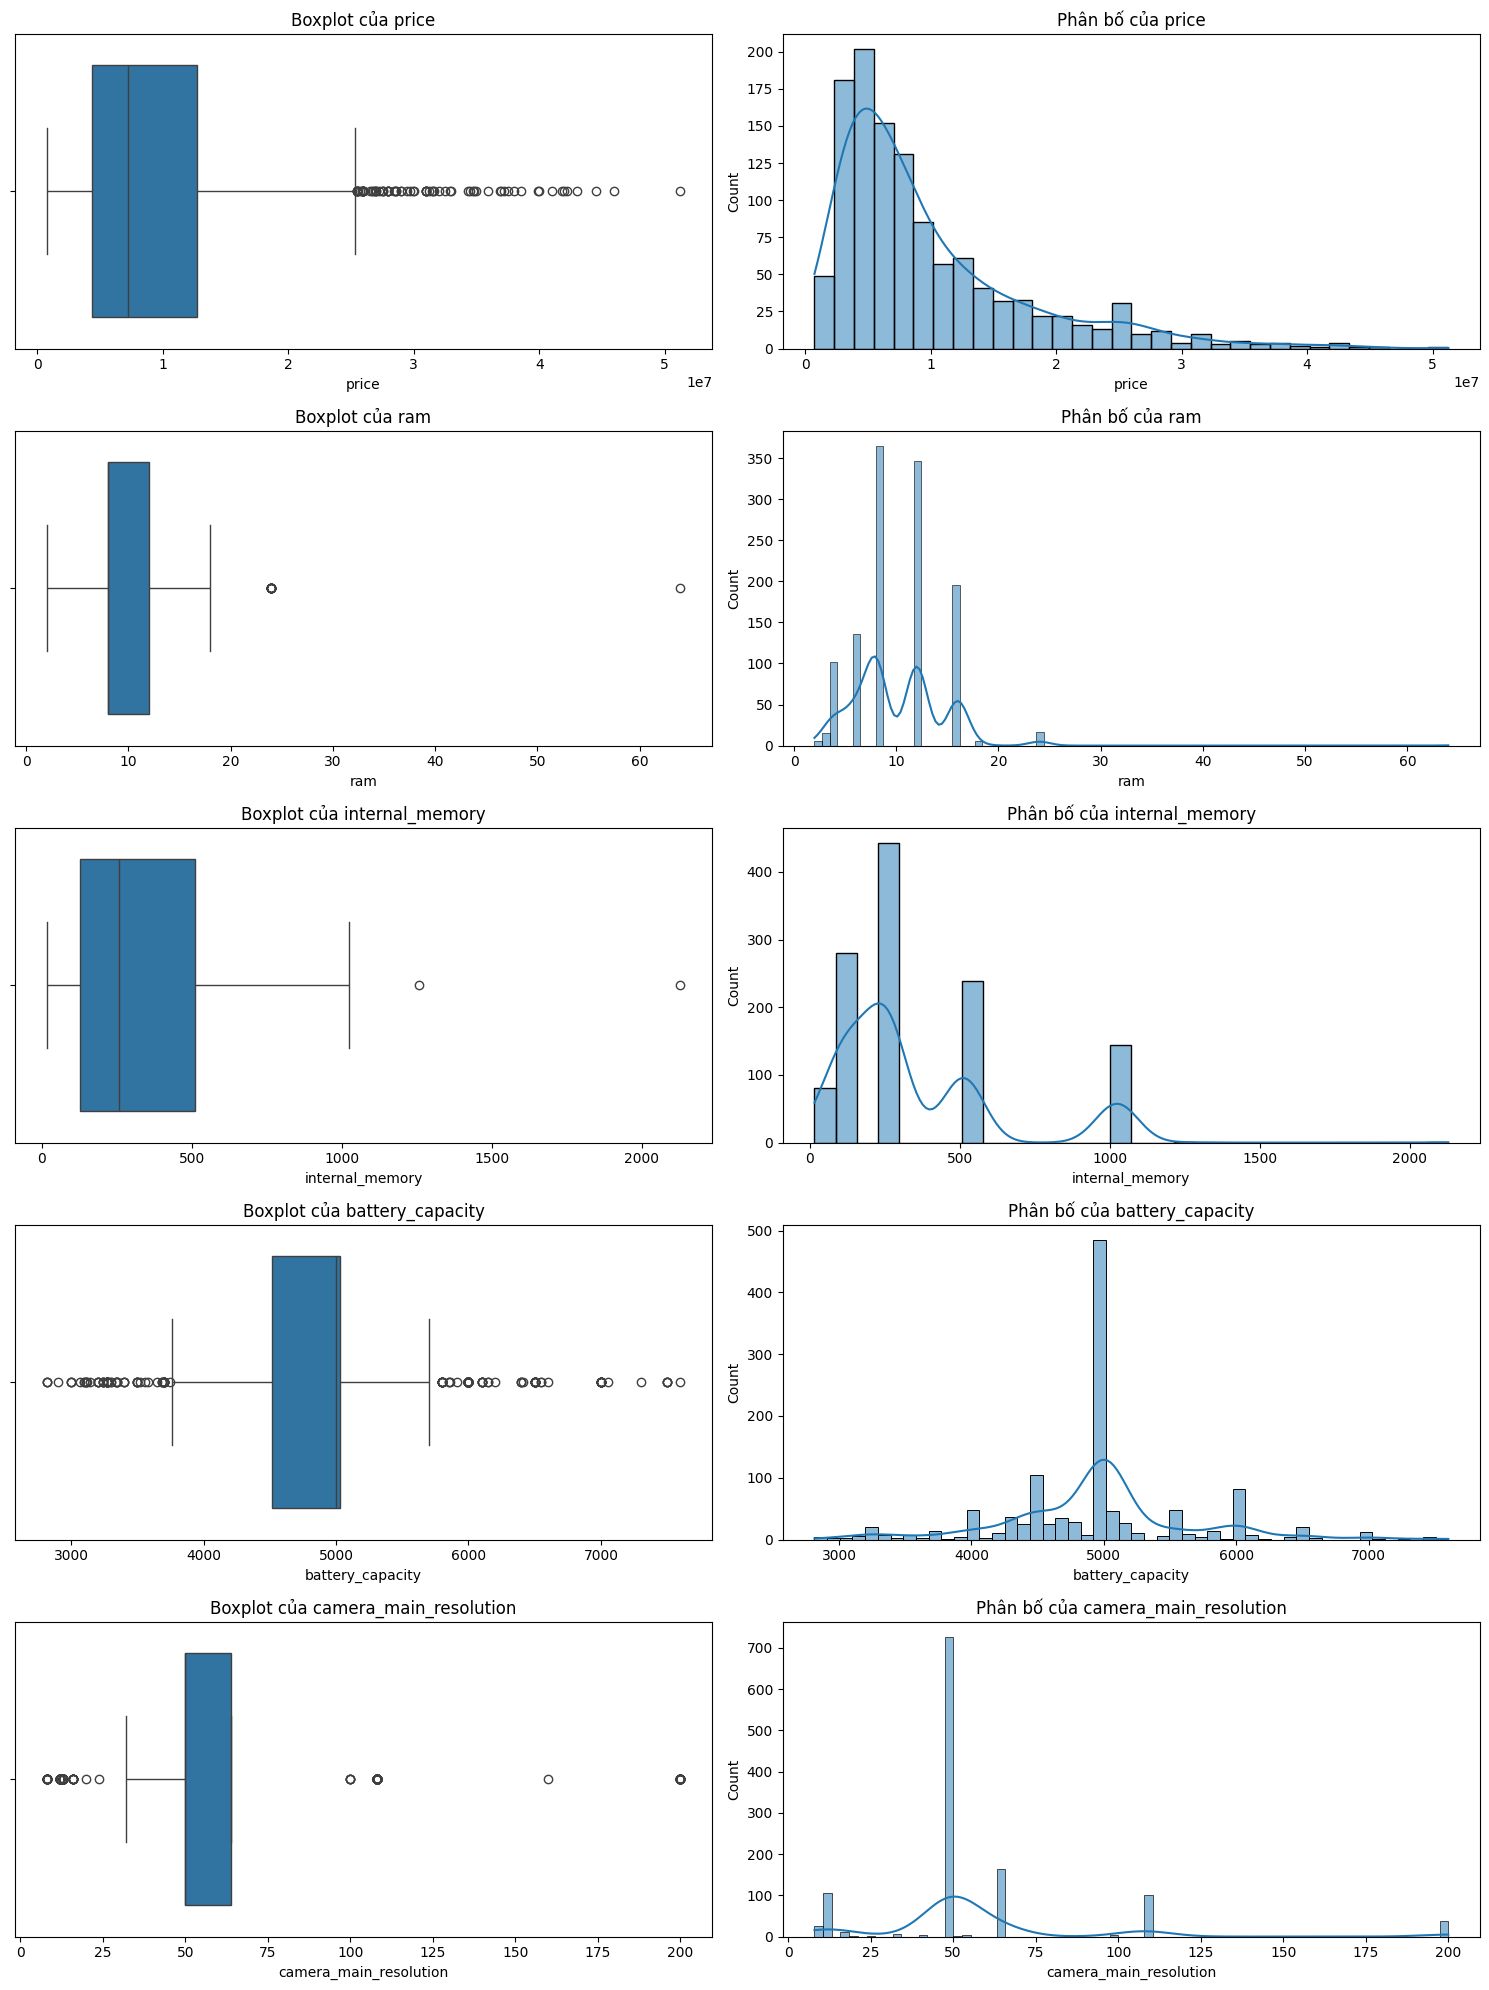

In [1165]:
# 1. Phân tích outliers bằng trực quan
def visualize_outliers(df, columns):
    plt.figure(figsize=(15, len(columns)*4))
    for i, col in enumerate(columns, 1):
        plt.subplot(len(columns), 2, i*2-1)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot của {col}')
        
        plt.subplot(len(columns), 2, i*2)
        sns.histplot(df[col], kde=True)
        plt.title(f'Phân bố của {col}')
    plt.tight_layout()
    plt.show()

# 2. Phân loại thay vì loại bỏ
def categorize_price(price):
    if price < 3000000: return 'Low'
    elif price < 8000000: return 'Medium'
    elif price < 15000000: return 'High'
    else: return 'Premium'

# Thực hiện
numeric_cols = ['price', 'ram', 'internal_memory', 'battery_capacity', 'camera_main_resolution']
visualize_outliers(df, numeric_cols)

# Thêm cột phân loại giá
df['price_category'] = df['price'].apply(categorize_price)

## Feature engineering


##### Brand and os


In [1166]:
import pandas as pd
import re

def extract_brand(name):
    # Convert to lowercase for easier matching
    name_lower = name.lower()
    
    # Define brand patterns
    brand_patterns = {
        'iphone': 'Apple',
        'apple': 'Apple',
        'samsung': 'Samsung',
        'xiaomi': 'Xiaomi',
        'asus': 'Asus',
        'bphone': 'Bphone',
        'redmi': 'Xiaomi',
        'infinix': 'Infinix',
        'inoi': 'Inoi',
        'itel': 'Itel',
        'nokia': 'Nokia',
        'sony': 'Sony',
        'nothing': 'Nothing',
        'nubia': 'Nubia',
        'poco': 'Xiaomi',
        'huawei': 'Huawei',
        'vivo': 'Vivo',
        'oppo': 'OPPO',
        'honor': 'Honor',
        'realme': 'Realme',
        'tecno': 'Tecno',
        'viettel': 'Viettel',
        'vsmart': 'Vsmart',
        'zte': 'ZTE',
        'google': 'Google',
        'meizu': 'Meizu',
        'motorola': 'Motorola',
        'moto': 'Motorola',
        'nio phone': 'NIO Phone',
        'nothing': 'Nothing',
        'oneplus': 'OnePlus',
        'tesla': 'Tesla',
        'unihertz': 'Unihertz',
        'lenovo': 'Lenovo',
        'red magic': 'Red Magic',
        'moonstone': 'Moonstone',
        'leeco': 'LeEco',
        'blackview': 'Blackview',
        'benco': 'Benco',
        'fairphone': 'Fairphone',
        'ulefone': 'Ulefone',
        'smartisan': 'Smartisan',
        'moondrop': 'Moondrop',
        'gionee': 'Gionee',
        'blu': 'Blu',
    }
    
    # Try to match brand at the start of the name
    for pattern, brand in brand_patterns.items():
        if name_lower.startswith(pattern):
            return brand
    
    # Look for brand anywhere in the name
    for pattern, brand in brand_patterns.items():
        if pattern in name_lower:
            return brand
    
    return 'Other'

def extract_os(brand):
    if brand == 'Apple':
        return 'iOS'
    else:
        return 'Android'


def extract_brand_and_os(df):
    # Extract brand
    df['brand'] = df['name'].apply(extract_brand)
    
    # Infer OS based on brand
    df['os'] = df['brand'].apply(extract_os)
    
    # Special case handling for specific products
    # If needed, you can add special rules for certain models
    
    return df


# Apply feature engineering
df = extract_brand_and_os(df)

# Preview the results
print(df[['name', 'brand', 'os']].head(10))

# Save the enhanced dataset
df.to_csv(base_data_clean_path + 'feature_engineering.csv', index=False)

                          name brand       os
0  ASUS ROG Phone 6 12GB 256GB  Asus  Android
1             Asus ROG Phone 2  Asus  Android
2       Asus ROG Phone 3 Elite  Asus  Android
3     Asus ROG Phone 3 Tencent  Asus  Android
4            Asus ROG Phone 5S  Asus  Android
5          Asus ROG Phone 5 5G  Asus  Android
6            Asus ROG Phone 6D  Asus  Android
7   Asus ROG Phone 6D Ultimate  Asus  Android
8             Asus ROG Phone 6  Asus  Android
9         Asus ROG Phone 6 Pro  Asus  Android


##### sceen_resolution -> to K


In [1167]:
# sceen_resolution cleaning
# Định nghĩa độ phân giải phổ biến cho chuẩn K
K_RESOLUTIONS = {
    "HD": (1280, 720),
    "FHD": (1920, 1080),
    "2K": (2560, 1440),
    "2.5K": (2880, 1620),
     "3K": (3200, 1800),
    "4K": (3840, 2160),
    "5K": (5120, 2880),
    "6K": (6144, 3160),
    "8K": (7680, 4320)
}

def resolution_to_k(width, height):
    """
    Xác định độ phân giải gần nhất theo chuẩn K.
    """
    min_diff = float('inf')
    best_match = "Unknown"

    for k, (w, h) in K_RESOLUTIONS.items():
        diff = abs(width - w) + abs(height - h)  # Tính khoảng cách
        if diff < min_diff:
            min_diff = diff
            best_match = k

    return best_match


def extract_resolution_features(df, col_name="screen_resolution"):
    """
    Feature engineering: Tách độ phân giải thành nhiều cột.
    :param df: DataFrame chứa cột độ phân giải
    :param col_name: Tên cột chứa độ phân giải
    :return: DataFrame với các cột mới
    """
    
    # Tách chiều rộng và chiều cao
    df[['screen_width', 'screen_height']] = df[col_name].str.split(' x ', expand=True).astype(float)

    # Thêm các feature mới
    df["screen_resolution_k"] = df.apply(lambda row: resolution_to_k(row["screen_width"], row["screen_height"]), axis=1)

    # không lưu screen_witdh, screen_height
    df.drop(columns=['screen_width', 'screen_height'], inplace=True)
    
    
    return df

# Chuẩn hóa và tạo feature
df = extract_resolution_features(df, col_name="screen_resolution")


In [1168]:
import re

def extract_chip_model(cpu_string):
    """
    Trích xuất tên loại chip từ thông tin CPU
    """
    if not cpu_string or not isinstance(cpu_string, str):
        return "Unknown"
    
    cpu_lower = cpu_string.lower()
    
    # Pattern cho các loại chip phổ biến
    chip_patterns = [
        # Qualcomm Snapdragon
        (r'snapdragon\s*(\d+\s*(?:gen\s*\d+|plus|ultra|pro|g|e|c)?\+?)', 'Snapdragon {0}'),
        (r'sm\d+[a-z]*-?(\d+)', 'Snapdragon {0}'),  # SM8450 = Snapdragon 8 Gen 1
        
        # MediaTek
        (r'dimensity\s*(\d+\s*(?:ultra|max|pro|plus|\+)?)', 'Dimensity {0}'),
        (r'helio\s*([a-z]\d+\s*(?:ultra|max|pro|plus|\+)?)', 'Helio {0}'),
        (r'mt\d+[a-z]*-?(\d+)', 'MediaTek {0}'),
        
        # Apple
        (r'a(\d+)\s*(?:bionic)?', 'A{0} Bionic'),
        (r'm(\d+)\s*(?:pro|max|ultra)?', 'M{0}'),
        
        # Samsung
        (r'exynos\s*(\d+(?:\s*\d*)?)', 'Exynos {0}'),
        
        # HiSilicon
        (r'kirin\s*(\d+(?:\s*\d*)?(?:\s*(?:pro|plus|e|\+))?)', 'Kirin {0}'),
        
        # Google
        (r'tensor\s*(g\d+|\d+|)', 'Tensor {0}'),
        
        # Unisoc
        (r'tiger\s*([a-z]\d+(?:\s*\d*)?)', 'Tiger {0}'),
        (r'unisoc\s*([a-z]\d+(?:\s*\d*)?)', 'Unisoc {0}'),
    ]
    
    # Tìm kiếm các mẫu trong văn bản CPU
    for pattern, template in chip_patterns:
        match = re.search(pattern, cpu_lower)
        if match:
            model = match.group(1).strip()
            if model:  # Đảm bảo model không trống
                return template.format(model.upper() if model.startswith('g') else model)
    
    # Nếu không tìm thấy mẫu cụ thể, thử tìm bất kỳ số model nào
    general_match = re.search(r'(\w+)\s*(\d+\w*(?:\s*(?:gen|plus|ultra|pro|max|\+)?\s*\d*))', cpu_lower)
    if general_match:
        brand = general_match.group(1).capitalize()
        model = general_match.group(2)
        return f"{brand} {model}"
    
    # Nếu không tìm được gì, trả về chuỗi gốc đã làm sạch
    return re.sub(r'\s+', ' ', cpu_string).strip() if cpu_string else "Unknown"


# Apply feature engineering
df = extract_brand_and_os(df)

# Áp dụng hàm để tạo cột mới 'chip_model'
df['chip_model'] = df['chipset'].apply(extract_chip_model)  # Hoặc df['cpu'] tùy vào dữ liệu

# Preview the results
print(df[['name', 'brand', 'os']].head(10))

# Save the enhanced dataset
df.to_csv(base_data_clean_path + 'feature_engineering.csv', index=False)

                          name brand       os
0  ASUS ROG Phone 6 12GB 256GB  Asus  Android
1             Asus ROG Phone 2  Asus  Android
2       Asus ROG Phone 3 Elite  Asus  Android
3     Asus ROG Phone 3 Tencent  Asus  Android
4            Asus ROG Phone 5S  Asus  Android
5          Asus ROG Phone 5 5G  Asus  Android
6            Asus ROG Phone 6D  Asus  Android
7   Asus ROG Phone 6D Ultimate  Asus  Android
8             Asus ROG Phone 6  Asus  Android
9         Asus ROG Phone 6 Pro  Asus  Android


In [1169]:
data_encode = df.copy()
# Giữ lại top 20 giá trị phổ biến nhất, gộp các giá trị còn lại thành "Other"
top_screen_tech = data_encode['screen_tech'].value_counts().nlargest(20).index
data_encode['screen_tech_grouped'] = data_encode['screen_tech'].apply(lambda x: x if x in top_screen_tech else 'Other')

# One-Hot Encoding cho biến screen_Tech sau khi gộp
data_encode = pd.get_dummies(data_encode, columns=['screen_tech_grouped'], drop_first=True)
# One-Hot Encoding cho biến screen_resolution_k
data_encode = pd.get_dummies(data_encode, columns=['screen_resolution_k'], drop_first=True)
top_brand = data_encode['brand'].value_counts().nlargest(10).index
# Giữ lại top 10 giá trị phổ biến nhất, gộp các giá trị còn lại thành "Other"
data_encode['brand'] = data_encode['brand'].apply(lambda x: x if x in top_brand else 'Other')
# One-Hot Encoding cho biến brand sau khi gộp
data_encode = pd.get_dummies(data_encode, columns=['brand'], drop_first=True)
# Giữ lại top 20 chip_model phổ biến nhất, gộp các giá trị còn lại thành "Other"
top_chip_model = data_encode['chip_model'].value_counts().nlargest(10).index
data_encode['chip_model_grouped'] = data_encode['chip_model'].apply(lambda x: x if x in top_chip_model else 'Other')

# One-Hot Encoding cho biến chip_model sau khi gộp
data_encode = pd.get_dummies(data_encode, columns=['chip_model_grouped'], drop_first=True)

display(data_encode.head())  # Xem trước vài dòng sau khi mã hóa



,name,url,price,chipset,ram,internal_memory,screen_size,screen_resolution,screen_tech,refresh_rate,...,chip_model_grouped_Helio G99,chip_model_grouped_Other,chip_model_grouped_Snapdragon 680,chip_model_grouped_Snapdragon 695,chip_model_grouped_Snapdragon 8 e,chip_model_grouped_Snapdragon 8 gen 1,chip_model_grouped_Snapdragon 8 gen 2,chip_model_grouped_Snapdragon 8 gen 3,chip_model_grouped_Snapdragon 865,chip_model_grouped_Snapdragon 888
0,ASUS ROG Phone 6 12GB 256GB,https://cellphones.com.vn/asus-rog-phone-6-12g...,14490000.0,Qualcomm Snapdragon 8 thế hệ 1,12.0,256,6.78,1080 x 2448,AMOLED,60.0,...,False,True,False,False,False,False,False,False,False,False
1,Asus ROG Phone 2,https://mobilecity.vn/asus/asus-rog-phone-2.html,11950000.0,Qualcomm SM8150 Snapdragon 855 8 nhân GPU Adre...,12.0,1024,6.59,1080 x 2340,AMOLED,120.0,...,False,True,False,False,False,False,False,False,False,False
2,Asus ROG Phone 3 Elite,https://mobilecity.vn/asus/asus-rog-phone-3-st...,10750000.0,Qualcomm SM8250 Snapdragon 865,12.0,256,6.59,1080 x 2340,AMOLED,144.0,...,False,False,False,False,False,False,False,False,True,False
3,Asus ROG Phone 3 Tencent,https://mobilecity.vn/asus/asus-rog-phone-3.html,11450000.0,Qualcomm SM8250 Snapdragon 865 8 nhân GPU Adre...,16.0,512,6.59,1080 x 2340,AMOLED,144.0,...,False,False,False,False,False,False,False,False,True,False
4,Asus ROG Phone 5S,https://mobilecity.vn/asus/asus-rog-phone-5s.html,14450000.0,Qualcomm SM8350 Snapdragon 888 5G 8 nhân GPU A...,16.0,512,6.78,1080 x 2448,AMOLED,144.0,...,False,False,False,False,False,False,False,False,False,True
